# Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

## Objective
In this project, we will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [1]:
import pandas as pd
import numpy as np
import warnings

from scipy import special 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import math
from IPython.display import Markdown, display ,HTML


from sklearn.model_selection import train_test_split


sns.set(style="whitegrid")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', -1) # make sure data and columns are displayed correctly withput purge
pd.options.display.float_format = '{:20,.2f}'.format # display float value with correct precision 


warnings.filterwarnings('ignore')

/var/folders/4f/95d162pj1wdgx71km0thbxt00000gn/T/ipykernel_1373/3985854905.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) # make sure data and columns are displayed correctly withput purge


In [2]:
def log(string):
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))
    
def header_red(string):
    display(Markdown("> <span style='color:red'>"+string))   

def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
    
def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix
        
def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header("Columns with only one unique value : "+str(lenght))
    if lenght == 0 :
        header_red("No columns with only one unique values.")  
    else :    
        log("Columns with only one unique value :")
        for index,item in enumerate(drop_value_col) :
            print(index,".",item)
            
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 


def list_potential_categorical_type(dataframe,main) :
    header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

def plot_data_type_pie_chat(dataframe) : 
        header("Stats for Datatype Percentage Distribution")
        dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
        dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
        trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
        layout = go.Layout(title="Datatype Percentage Distribution")
        fig = go.Figure(data=[trace], layout=layout)    
        py.offline.iplot(fig)
    
def get_potential_categorical_type(dataframe,main,unique_count) :
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    metadata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 
           
def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 10 , black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

In [3]:
tele_data = pd.read_csv("telecom_churn_data.csv")
tele_data.head(5)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,...,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,NaN,252.00,252.00,252.00,NaN,30.13,1.32,5.75,0.00,83.57,150.76,109.61,0.00,212.17,212.17,212.17,NaN,212.17,212.17,212.17,NaN,0.00,0.00,0.00,NaN,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.00,1.00,1.00,NaN,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,355.07,268.32,86.28,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,0.00,0.00,2.91,0.00,0.00,35.39,150.51,299.54,72.11,0.23,...,NaN,NaN,154.00,50.00,NaN,0.00,108.07,365.47,0.00,0.00,0.00,0.00,0.00,NaN,0.00,0.00,NaN,NaN,28.61,7.60,NaN,NaN,0.00,0.00,NaN,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,NaN,1.00,1.00,NaN,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,189.06,210.23,290.71,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.00,0.00,0.00,38.49,0.00,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,22.24,0.00,135.54,45.76,0.48,60.66,67.41,67.66,64.81,4.34,...,0.00,NaN,NaN,NaN,46.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.42,NaN,NaN,NaN,2.84,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,NaN,NaN,NaN,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,251.10,508.05,389.50,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.00,54.86,44.38,0.00,0.00,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,2.06,0.00,0.00,0.00,0.00,183.03,118.68,37.99,83.03,26.23,...,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,309.88,238.17,163.43,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,1.93,0.00,0.00,0.00,0.00,117.96,241.33,208.16,98.61,0.00,...,NaN,56.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,NaN,NaN,NaN,1526,0.00,0.00,0.00,0.00


In [4]:
tele_data.shape

(99999, 226)

In [5]:
# Let us first extract list of columns containing recharge amount
amt_recharge_columns =  tele_data.columns[tele_data.columns.str.contains('rech_amt|rech_data')]
print(amt_recharge_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


In [6]:
# Checking missing values percentages
tele_data_null_check = 100*tele_data.loc[:,amt_recharge_columns].isnull().sum()/len(tele_data)
df = pd.DataFrame(tele_data_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
total_rech_amt_9,0.000000
max_rech_amt_6,0.000000
max_rech_amt_7,0.000000
max_rech_amt_8,0.000000
max_rech_amt_9,0.000000
date_of_last_rech_data_6,74.846748
date_of_last_rech_data_7,74.428744


In [7]:
tele_data.loc[:,amt_recharge_columns].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,"99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","99,999.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00","25,153.00","25,571.00","26,339.00","25,922.00"
mean,327.51,322.96,324.16,303.35,104.64,104.75,107.73,101.94,2.46,2.67,2.65,2.44,126.39,126.73,125.72,124.94,192.60,200.98,197.53,192.73
std,398.02,408.11,416.54,404.59,120.61,124.52,126.90,125.38,2.79,3.03,3.07,2.52,108.48,109.77,109.44,111.36,192.65,196.79,191.30,188.40
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.50,0.50,1.00
25%,109.00,100.00,90.00,52.00,30.00,30.00,30.00,28.00,1.00,1.00,1.00,1.00,25.00,25.00,25.00,25.00,82.00,92.00,87.00,69.00
50%,230.00,220.00,225.00,200.00,110.00,110.00,98.00,61.00,1.00,1.00,1.00,2.00,145.00,145.00,145.00,145.00,154.00,154.00,154.00,164.00
75%,437.50,428.00,434.50,415.00,120.00,128.00,144.00,144.00,3.00,3.00,3.00,3.00,177.00,177.00,179.00,179.00,252.00,252.00,252.00,252.00
max,"35,190.00","40,335.00","45,320.00","37,235.00","4,010.00","4,010.00","4,449.00","3,399.00",61.00,54.00,60.00,84.00,"1,555.00","1,555.00","1,555.00","1,555.00","7,546.00","4,365.00","4,076.00","4,061.00"


In [8]:
tele_data['total_rech_data_6'] = tele_data['total_rech_data_6'].replace(np.NaN,0.0)
tele_data['total_rech_data_7'] = tele_data['total_rech_data_7'].replace(np.NaN,0.0)
tele_data['total_rech_data_8'] = tele_data['total_rech_data_8'].replace(np.NaN,0.0)

In [9]:
tele_data['av_rech_amt_data_6'] = tele_data['av_rech_amt_data_6'].replace(np.NaN,0.0)
tele_data['av_rech_amt_data_7'] = tele_data['av_rech_amt_data_7'].replace(np.NaN,0.0)
tele_data['av_rech_amt_data_8'] = tele_data['av_rech_amt_data_8'].replace(np.NaN,0.0)

In [10]:
# let's adding new column total recharge amount for data: total_rech_amt_data for calculating High Value customer process
tele_data['total_rech_amt_data_6'] = tele_data.av_rech_amt_data_6 * tele_data.total_rech_data_6
tele_data['total_rech_amt_data_7'] = tele_data.av_rech_amt_data_7 * tele_data.total_rech_data_7
tele_data['total_rech_amt_data_8'] = tele_data.av_rech_amt_data_8 * tele_data.total_rech_data_8

In [11]:
tele_data['total_avg_rech_amnt_6_7_GPhase'] = (tele_data.total_rech_amt_6 + tele_data.total_rech_amt_data_6 \
                                               + tele_data.total_rech_amt_7+ tele_data.total_rech_amt_data_7)/2

In [12]:
# create a filter for values greater than 70th percentile of total average recharge amount for good phase 
high_value_filter = tele_data.total_avg_rech_amnt_6_7_GPhase.quantile(0.7)

log('70 percentile of 6th and 7th months avg recharge amount: '+str(high_value_filter))

tele_data_high_val_cust = tele_data[tele_data.total_avg_rech_amnt_6_7_GPhase > high_value_filter]
log('Dataframe Shape after Filtering High Value Customers: ' + str(tele_data_high_val_cust.shape))

> <span style='color:blue'>70 percentile of 6th and 7th months avg recharge amount: 478.0</span>

> <span style='color:blue'>Dataframe Shape after Filtering High Value Customers: (29953, 230)</span>

In [13]:
high_val_cust_9 = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

In [14]:
# Checking the NA/Null values are present or Not
df = 100*tele_data_high_val_cust.loc[:,high_val_cust_9].isnull().sum()/len(tele_data_high_val_cust)
df = pd.DataFrame(df)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_ic_mou_9,0.000000
total_og_mou_9,0.000000
vol_2g_mb_9,0.000000
vol_3g_mb_9,0.000000


In [15]:
# Initially set all the values as 0
tele_data_high_val_cust['churn']= 0

In [16]:
#is_churned boolean flag for customers where above values are zero
is_churned = (tele_data_high_val_cust.total_ic_mou_9 == 0) & \
             (tele_data_high_val_cust.total_og_mou_9 == 0) & \
             (tele_data_high_val_cust.vol_2g_mb_9 ==0) & \
             (tele_data_high_val_cust.vol_3g_mb_9 ==0)

# set all which having is_churned True condition as 1
tele_data_high_val_cust.loc[is_churned,'churn']=1

# let us check what's the % of churned customers
100*tele_data_high_val_cust.churn.sum()/len(tele_data_high_val_cust)

8.122725603445398

In [17]:
churn_month_columns =  tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('_9')]

# droping all columns w.r.t. to the churn phase
tele_data_high_val_cust.drop(churn_month_columns,axis=1,inplace=True)

# Exploratory Data Analysis (EDA)

In [18]:
list_potential_categorical_type(get_meta_data(tele_data_high_val_cust),tele_data_high_val_cust) # data convert columns to appropriate formats and  handle missing values


------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
fb_user_8,float64,2,"[1.0, nan, 0.0]"


In [19]:
drop_col_with_unique_col =['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 
                          'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 
                          'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 
                          'std_og_t2c_mou_8',  'std_ic_t2o_mou_6', 
                          'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']

# Dropping above features with only one unique value as they will not add any value in building model

In [20]:
log("Features before dropping unique values : "+ str(tele_data_high_val_cust.shape[1]))
tele_data_high_val_cust.drop(drop_col_with_unique_col,axis=1,inplace=True)
log("Features after dropping unique values : "+ str(tele_data_high_val_cust.shape[1]))

> <span style='color:blue'>Features before dropping unique values : 177</span>

> <span style='color:blue'>Features after dropping unique values : 164</span>

In [21]:
meta_df = get_meta_data(tele_data_high_val_cust)
meta_df_count = meta_df[meta_df["Datatype"] == 'object']
date_col = meta_df_count.index.tolist()
date_col

['date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [22]:
tele_data_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/21/2014,7/16/2014,8/8/2014,6/21/2014,7/16/2014,8/8/2014
7,6/27/2014,7/25/2014,8/26/2014,NaN,NaN,NaN
8,6/25/2014,7/31/2014,8/30/2014,NaN,7/31/2014,8/23/2014
21,6/30/2014,7/31/2014,8/31/2014,NaN,NaN,NaN
23,6/18/2014,7/7/2014,8/24/2014,NaN,7/7/2014,8/6/2014


In [23]:
for col in date_col:
    tele_data_high_val_cust[col] = pd.to_datetime(tele_data_high_val_cust[col])
    

In [24]:
tele_data_high_val_cust[date_col].head(5)

,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,2014-06-21,2014-07-16,2014-08-08,2014-06-21,2014-07-16,2014-08-08
7,2014-06-27,2014-07-25,2014-08-26,NaT,NaT,NaT
8,2014-06-25,2014-07-31,2014-08-30,NaT,2014-07-31,2014-08-23
21,2014-06-30,2014-07-31,2014-08-31,NaT,NaT,NaT
23,2014-06-18,2014-07-07,2014-08-24,NaT,2014-07-07,2014-08-06


In [25]:
tele_data_high_val_cust.head(10)

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,...,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,NaN,0.00,NaN,...,252.00,0.00,0.00,0.00,1.00,1.00,1.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,212.17,212.17,212.17,212.17,212.17,212.17,0.00,0.00,0.00,0,0,0,0,0,0,1,1,1,0,0,0,1.00,1.00,1.00,968,30.40,0.00,101.20,3.58,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,60.86,75.14,77.84,0.00,0.18,10.01,4.50,0.00,6.50,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.00,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,378.09,288.18,63.04,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,130.26,143.48,98.28,0.00,0.00,0.00,0.00,0.00,10.23,0.00,...,23.00,NaN,2.00,3.00,NaN,0.00,0.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,NaN,0.00,19.83,NaN,0.00,0.00,NaN,0.00,0.00,0,1,0,0,1,3,0,0,0,0,0,0,NaN,1.00,1.00,315,21.03,910.65,122.16,0.00,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.04,94.09,129.74,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,763.29,934.69,938.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,720,0.00,0.00,0.00,0.00,0.00,0.00,0.00,640.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,131.91,133.68,182.14,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.01,0.00,0.10,0.00,17.71,0.00,...,179.00,NaN,0.00,0.00,NaN,2.00,2.00,0.00,356.00,270.00,0.00,0.48,0.01,0.00,599.09,"1,009.92",NaN,306.57,197.27,NaN,301.78,150.67,NaN,0.00,0.00,0,0,0,0,0,0,0,2,1,0,0,1,NaN,1.00,1.00,604,40.45,51.86,0.00,0.00,0.00,712.00,540.00,583.00,0
33,7000149764,977.02,"2,362.83",

In [26]:
list_potential_categorical_type(get_meta_data(tele_data_high_val_cust),tele_data_high_val_cust)

------ 

### Stats for potential Categorical datatype columns

,Datatype,Unique_Values_Count,Unique_Values
index,,,
monthly_3g_7,int64,15,"[1, 0, 2, 5, 3, 8, 4, 7, 6, 9, 11, 12, 14, 10, 16]"
monthly_3g_6,int64,12,"[1, 0, 4, 2, 3, 5, 7, 6, 9, 8, 11, 14]"
monthly_3g_8,int64,12,"[1, 0, 2, 7, 3, 4, 6, 5, 8, 10, 9, 16]"
monthly_2g_7,int64,6,"[0, 1, 2, 5, 4, 3]"
monthly_2g_8,int64,6,"[0, 1, 2, 5, 3, 4]"
monthly_2g_6,int64,5,"[0, 2, 1, 3, 4]"
night_pck_user_6,float64,2,"[0.0, nan, 1.0]"
night_pck_user_7,float64,2,"[0.0, nan, 1.0]"
night_pck_user_8,float64,2,"[0.0, nan, 1.0]"


### Creating box plot for  6th, 7th and 8th month

In [27]:

def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = tele_data_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.show()

In [28]:
recharge_amnt_columns =  tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'max_rech_amt_6',
 'max_rech_amt_7',
 'max_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_amt_data_6',
 'total_rech_amt_data_7',
 'total_rech_amt_data_8']

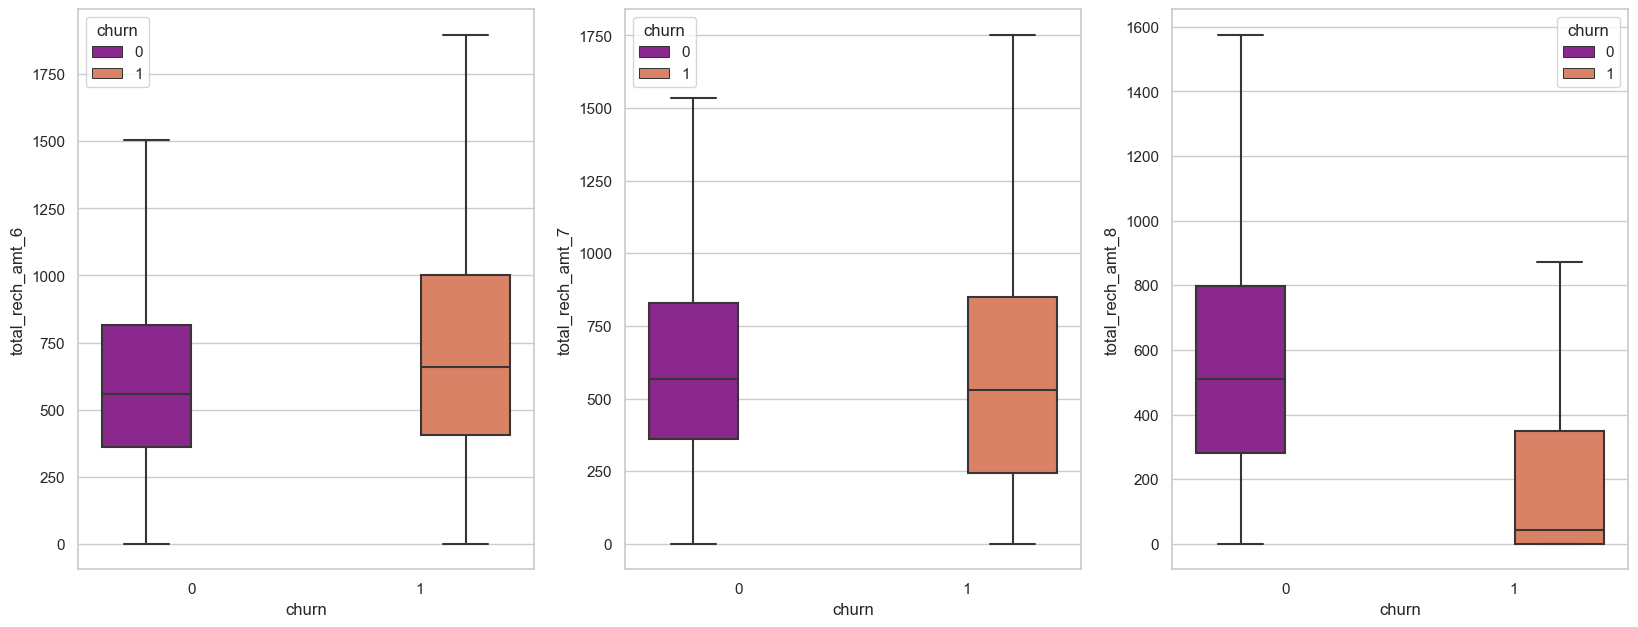

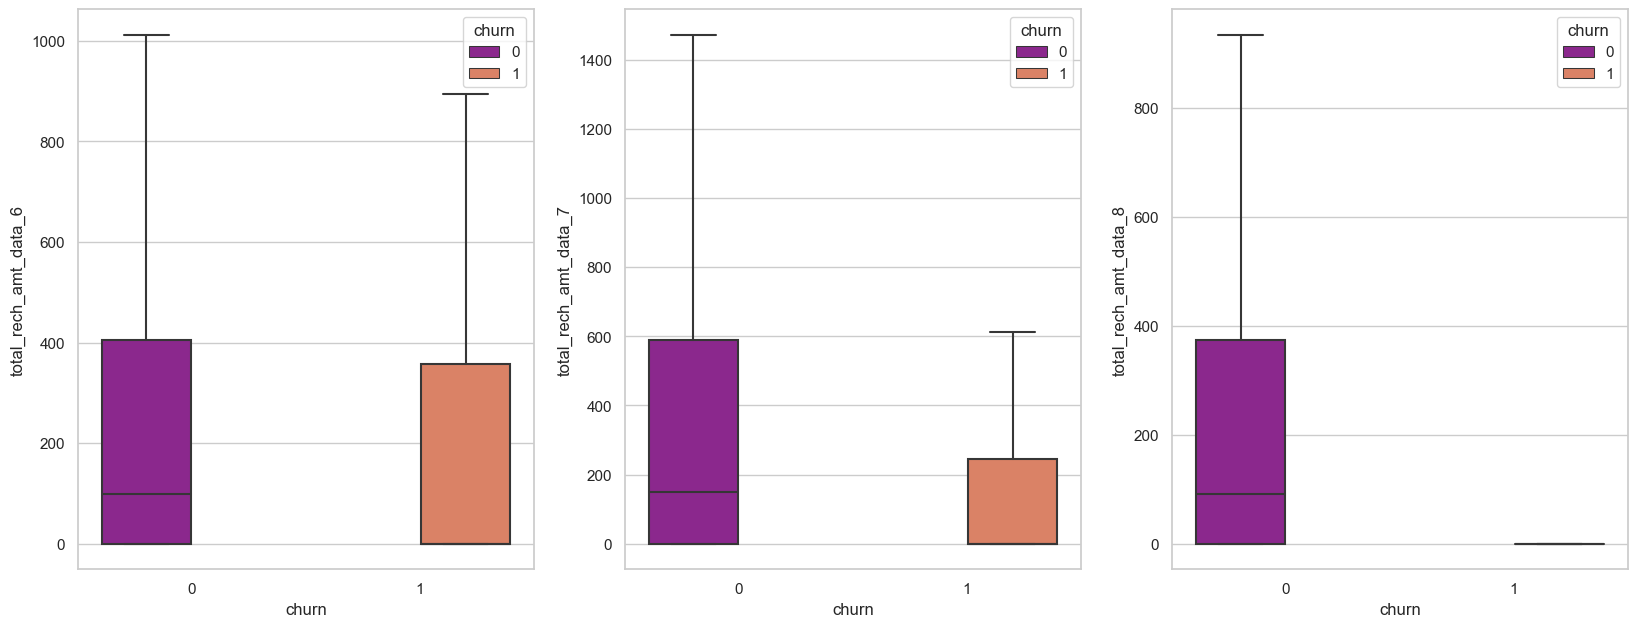

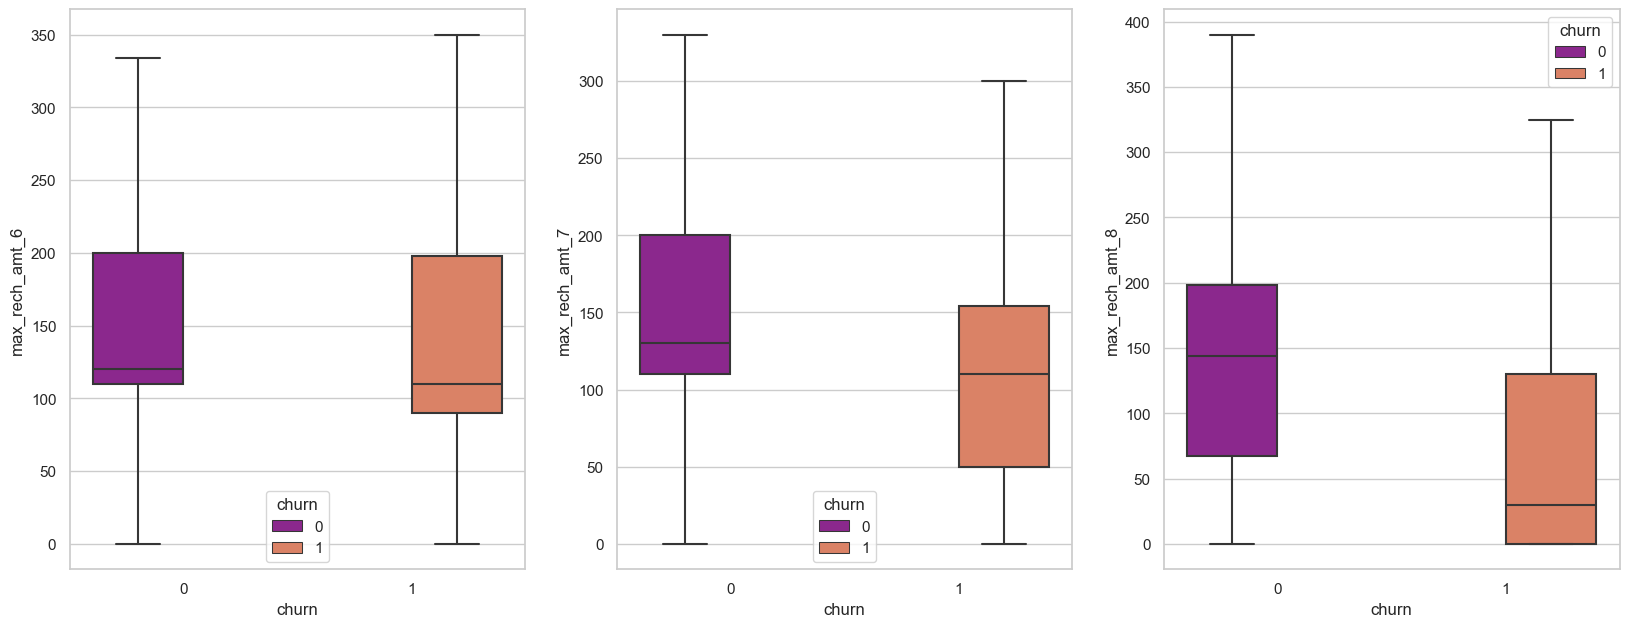

In [29]:
plot_box_chart('total_rech_amt') 
plot_box_chart('total_rech_amt_data')
plot_box_chart('max_rech_amt')# ploting box plot

In [30]:
#check other recharge related variables:
other_recharge = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('rech_num|max_rech_data',regex=True)]

# now checking the % of NA values for other recharge related variables
100*tele_data_high_val_cust.loc[:,other_recharge].isnull().sum()/len(tele_data_high_val_cust)

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
max_rech_data_6                   44.11
max_rech_data_7                   43.12
max_rech_data_8                   46.80
dtype: float64

In [31]:
tele_data_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].describe()

,max_rech_data_6,max_rech_data_7,max_rech_data_8
count,"16,740.00","17,038.00","15,935.00"
mean,139.80,140.44,136.35
std,118.89,120.30,119.57
min,1.00,1.00,1.00
25%,25.00,25.00,25.00
50%,152.00,152.00,152.00
75%,198.00,198.00,198.00
max,"1,555.00","1,555.00","1,555.00"


In [32]:
tele_data_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']] \
= tele_data_high_val_cust.loc[:,['max_rech_data_6','max_rech_data_7','max_rech_data_8']].replace(np.nan,0)
# Filling the missing values by 0 , means no recharge.

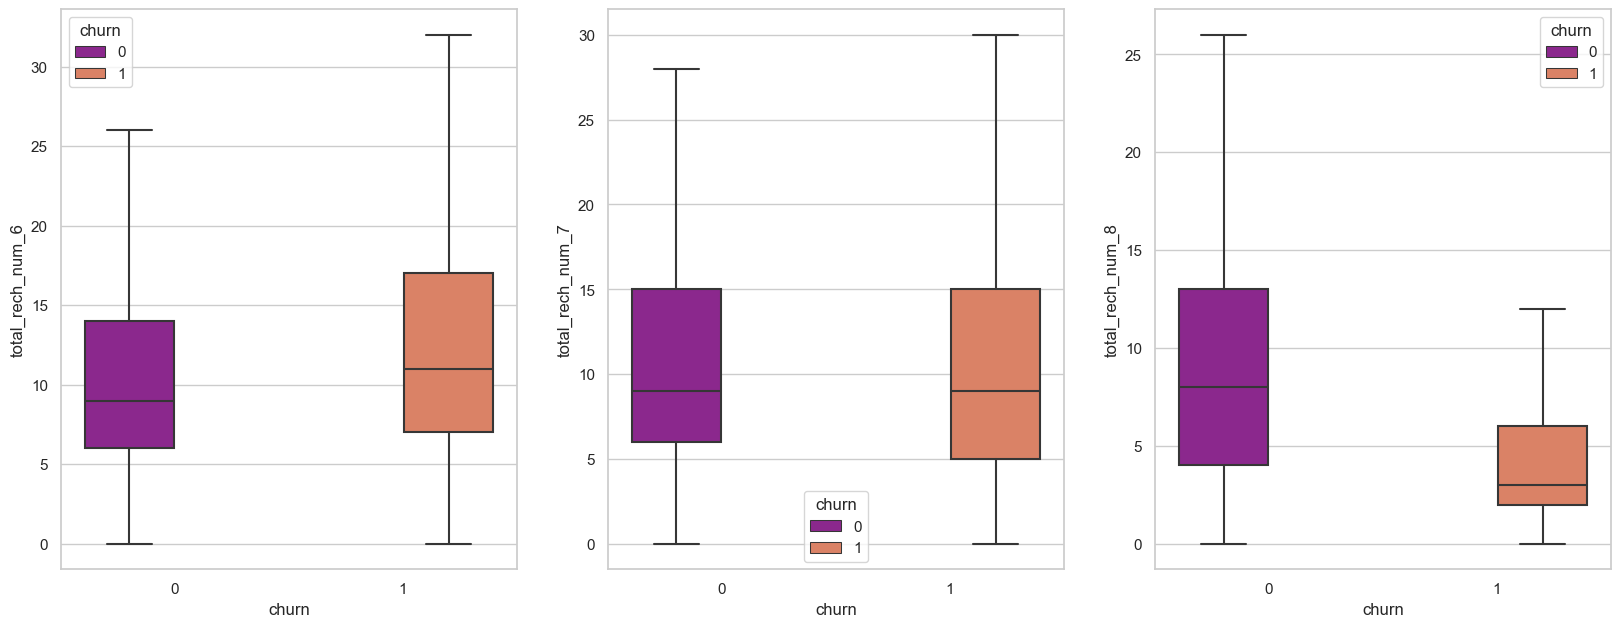

In [33]:
plot_box_chart('total_rech_num')

there is a huge drop in total recharge number also in the 8th month 

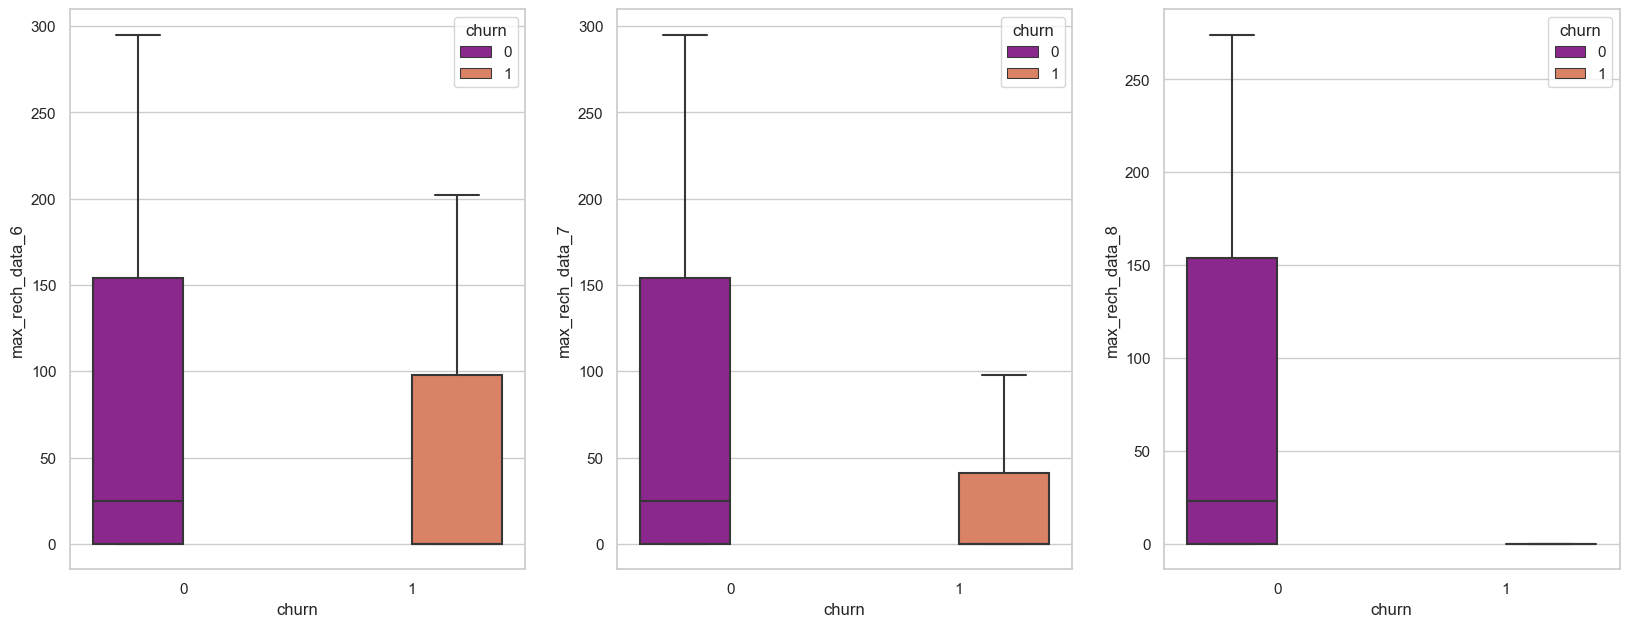

In [34]:
plot_box_chart('max_rech_data')

drop in maximum recharge for data also in the 8th month

In [35]:
last_day_rech_amt = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('day')] # the last day recharge amount columns

In [36]:
last_day_rech_amt.tolist()

['last_day_rch_amt_6', 'last_day_rch_amt_7', 'last_day_rch_amt_8']

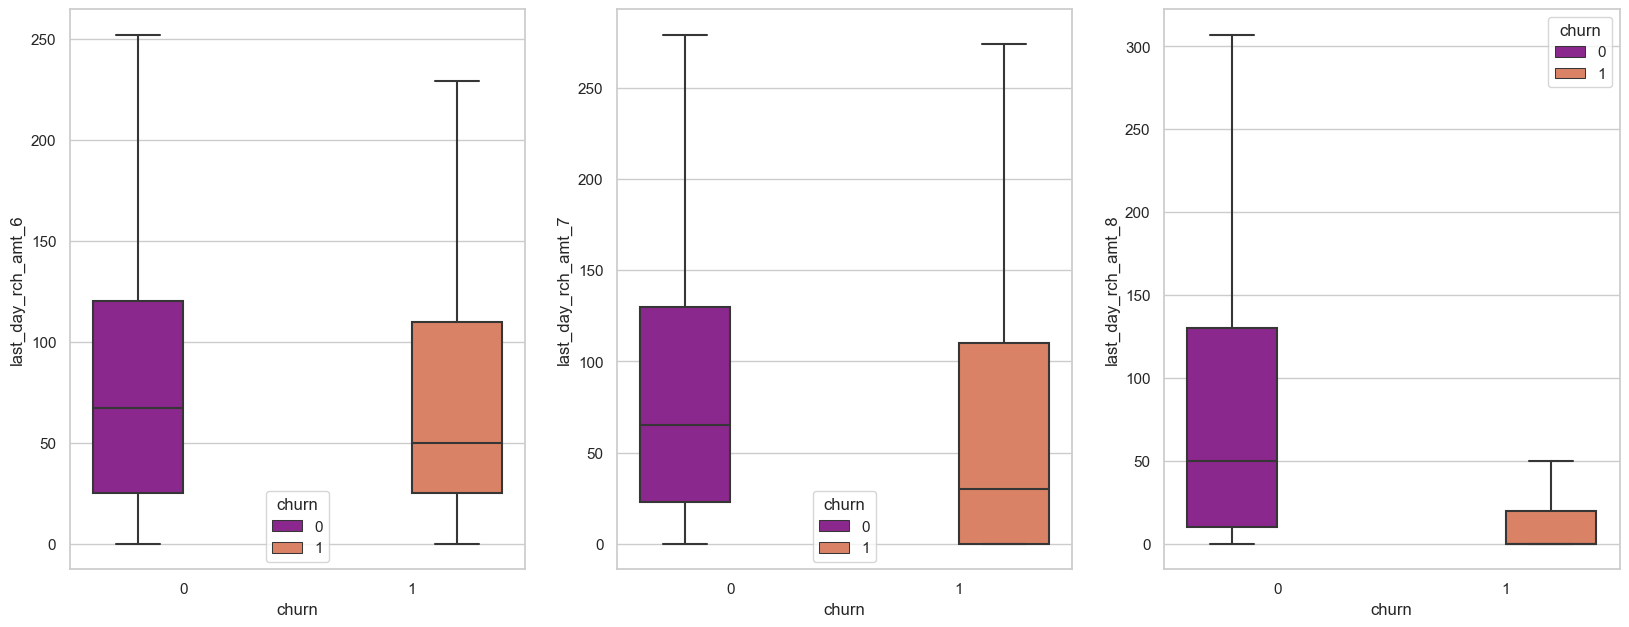

In [37]:
plot_box_chart('last_day_rch_amt')

here also huge drop in 8th month recharge amount for churned customers

In [38]:
usage_2g_and_3g = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('2g|3g',regex=True)] # 2g and 3g usages

In [39]:
percentage_3g_2g_null_check = 100*tele_data_high_val_cust.loc[:,usage_2g_and_3g].isnull().sum()/len(tele_data_high_val_cust.loc[:,usage_2g_and_3g])
df = pd.DataFrame(percentage_3g_2g_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)
# checking the percentage of NA values

,Null_Percentage
count_rech_2g_6,44.112443
count_rech_2g_7,43.117551
count_rech_2g_8,46.799987
count_rech_3g_6,44.112443
count_rech_3g_7,43.117551
count_rech_3g_8,46.799987
vol_2g_mb_6,0.000000
vol_2g_mb_7,0.000000
vol_2g_mb_8,0.000000
vol_3g_mb_6,0.000000


 We are getting more then 40% values are not available, we have 2G/3G volume usage based data available, we can drop these columns.

In [40]:
tele_data_high_val_cust.drop(['count_rech_2g_6','count_rech_2g_7',
              'count_rech_2g_8','count_rech_3g_6','count_rech_3g_7','count_rech_3g_8'
               ,'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8'],axis=1,inplace=True)

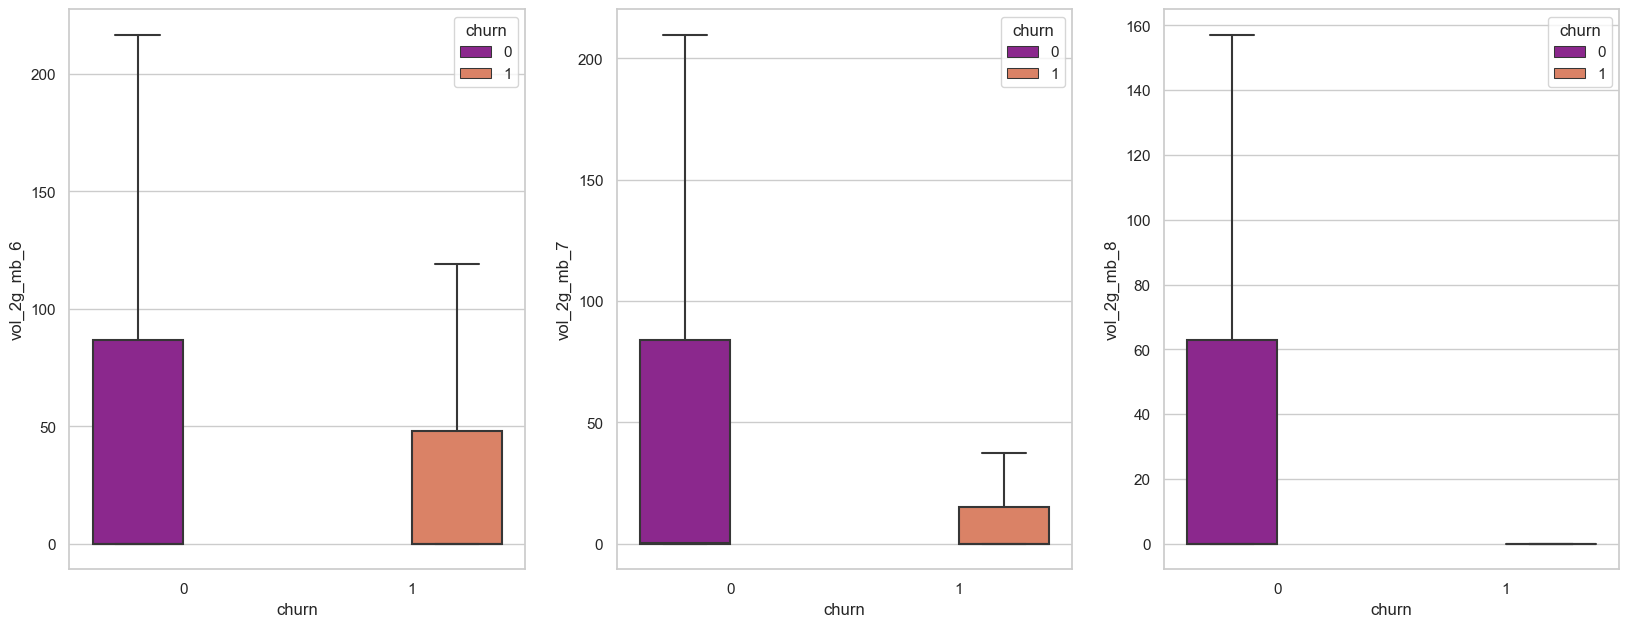

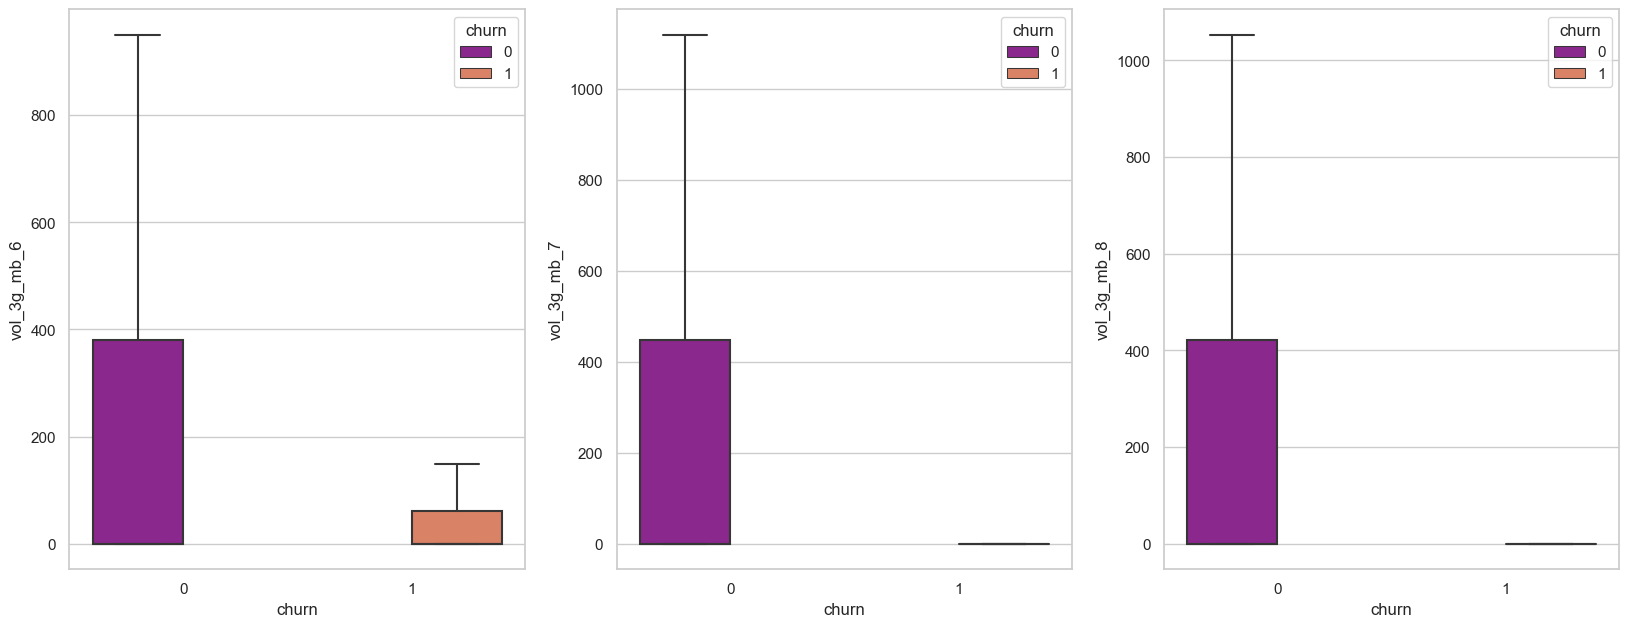

In [41]:
plot_box_chart('vol_2g_mb')
plot_box_chart('vol_3g_mb')

In [42]:
monthly_subcription_2g_3g = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g.tolist()
# monthly 2G/3G service schemes

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [43]:
# Null value
100*tele_data_high_val_cust.loc[:,monthly_subcription_2g_3g].isnull().sum()/len(tele_data_high_val_cust.loc[:,monthly_subcription_2g_3g])

monthly_2g_6                   0.00
monthly_2g_7                   0.00
monthly_2g_8                   0.00
monthly_3g_6                   0.00
monthly_3g_7                   0.00
monthly_3g_8                   0.00
dtype: float64

In [44]:
tele_data_high_val_cust[monthly_subcription_2g_3g].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   monthly_2g_6  29953 non-null  int64
 1   monthly_2g_7  29953 non-null  int64
 2   monthly_2g_8  29953 non-null  int64
 3   monthly_3g_6  29953 non-null  int64
 4   monthly_3g_7  29953 non-null  int64
 5   monthly_3g_8  29953 non-null  int64
dtypes: int64(6)
memory usage: 1.6 MB


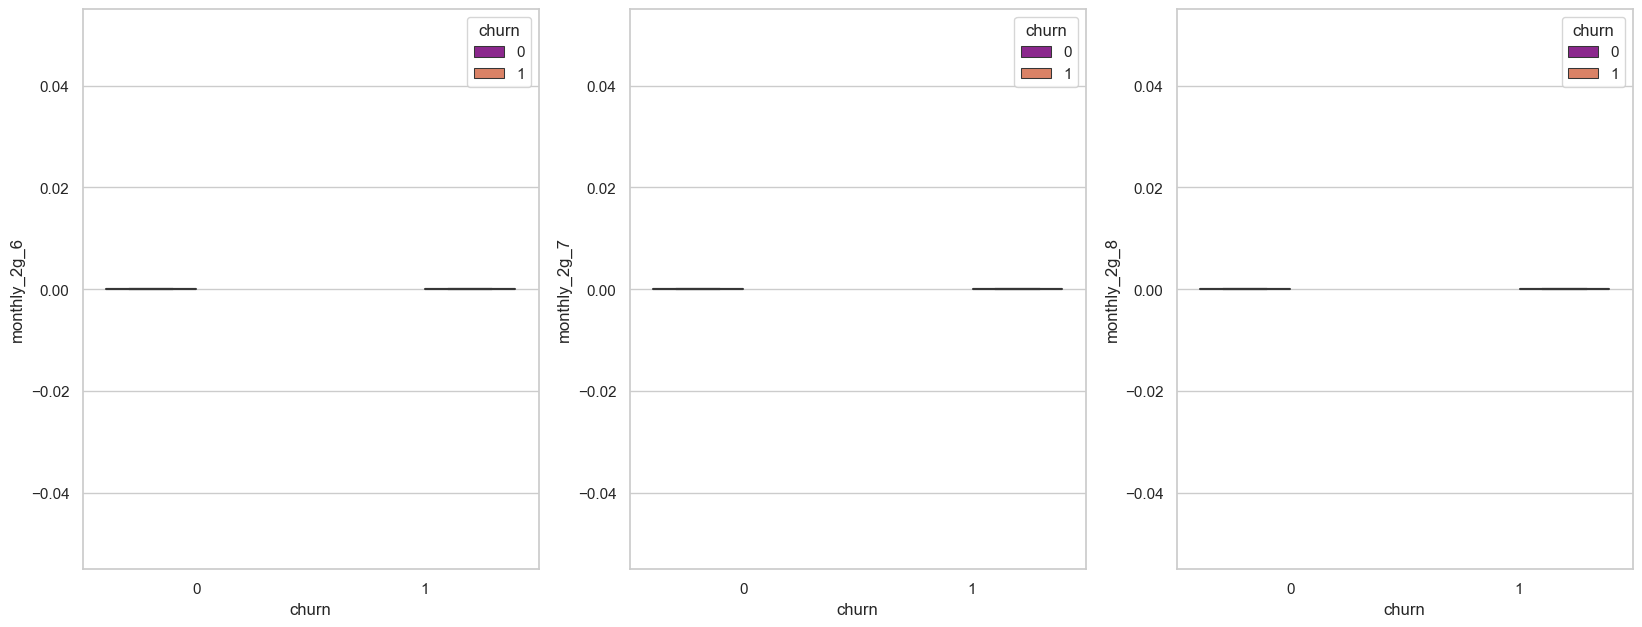

In [45]:
plot_box_chart('monthly_2g')

graph is not giving us proper results

In [46]:
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index= ['Non Churn'])
    mean_df_1 = pd.DataFrame([df_1.mean()],index=['Churn'])

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(8,4),rot=0)
    plt.show()
    
    return mean_bar

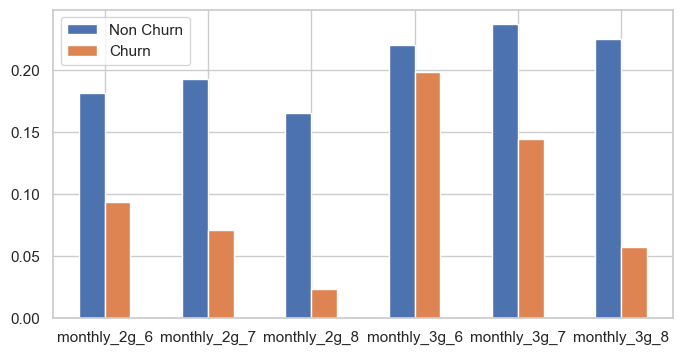

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.18,0.19,0.17,0.22,0.24,0.22
Churn,0.09,0.07,0.02,0.20,0.14,0.06


In [47]:
plot_mean_bar_chart(tele_data_high_val_cust, monthly_subcription_2g_3g)

there is a drop in monthly subscription for churned customers in 8th Month.

In [48]:
vbc_column = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('vbc_',regex=True)]
vbc_column.tolist()

['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g']

In [49]:
 # Renaming month named vbc columns to 6,7,8,9 format
tele_data_high_val_cust.rename(columns={'jun_vbc_3g':'vbc_3g_6','jul_vbc_3g':'vbc_3g_7','aug_vbc_3g':'vbc_3g_8'
                         ,'sep_vbc_3g':'vbc_3g_9'}, inplace=True)

In [50]:
tele_data_high_val_cust.drop('vbc_3g_9',axis=1,inplace=True) # drop 9th month col

In [51]:
vbc_column = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('vbc_3g',regex=True)]
vbc_column.tolist()

['vbc_3g_8', 'vbc_3g_7', 'vbc_3g_6']

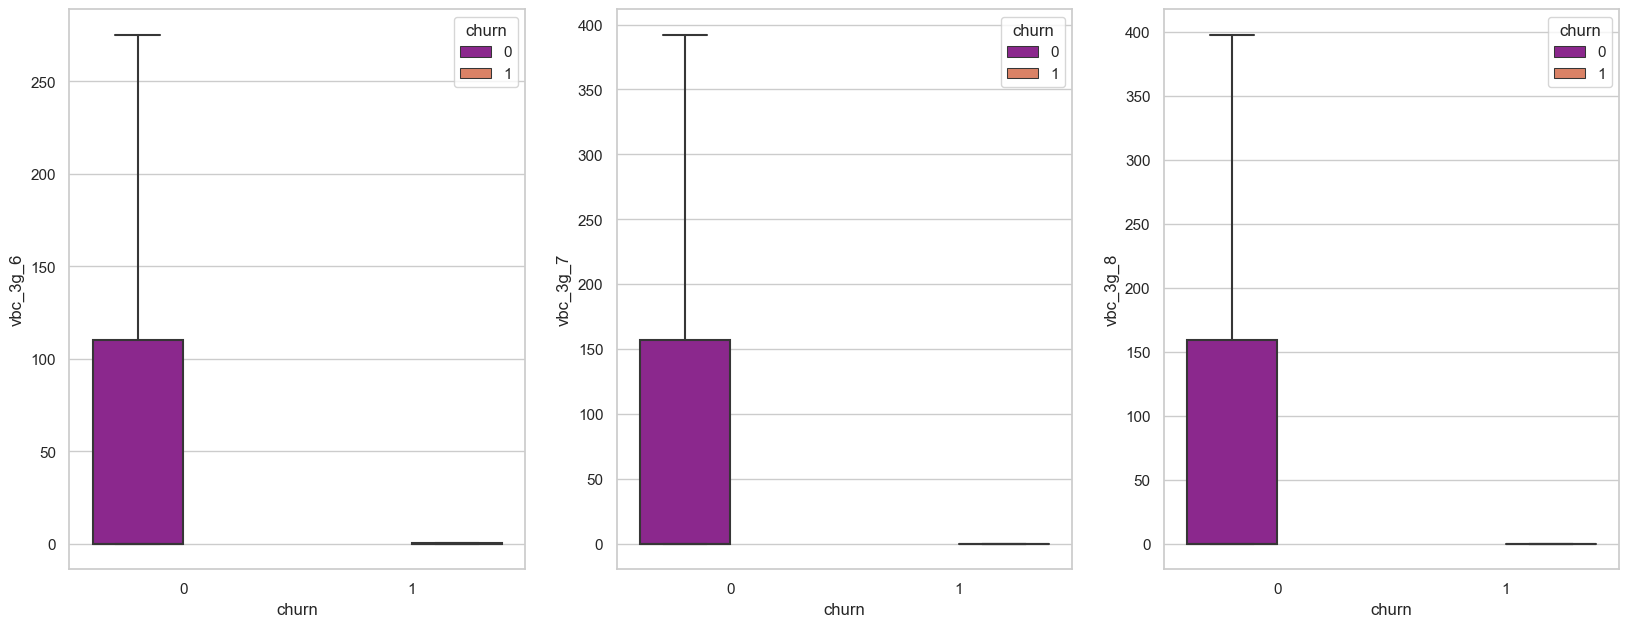

In [52]:
plot_box_chart('vbc_3g')

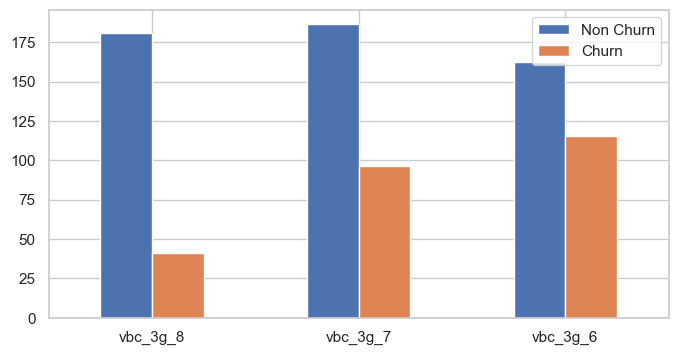

,vbc_3g_8,vbc_3g_7,vbc_3g_6
Non Churn,180.62,186.37,162.56
Churn,40.94,96.34,115.46


In [53]:
plot_mean_bar_chart(tele_data_high_val_cust, vbc_column)

In [54]:
# Service schemes with validity smaller than a month for 2G/3G
SC_2g_or_3g_col = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('sachet_2g|sachet_3g',regex=True)]

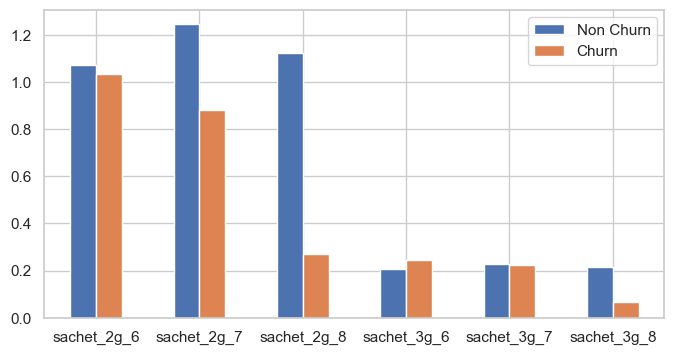

,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8
Non Churn,1.07,1.25,1.13,0.21,0.23,0.21
Churn,1.03,0.88,0.27,0.24,0.22,0.07


In [55]:
plot_mean_bar_chart(tele_data_high_val_cust, SC_2g_or_3g_col)

drop in sachet services in 8th month for churned cutsomers

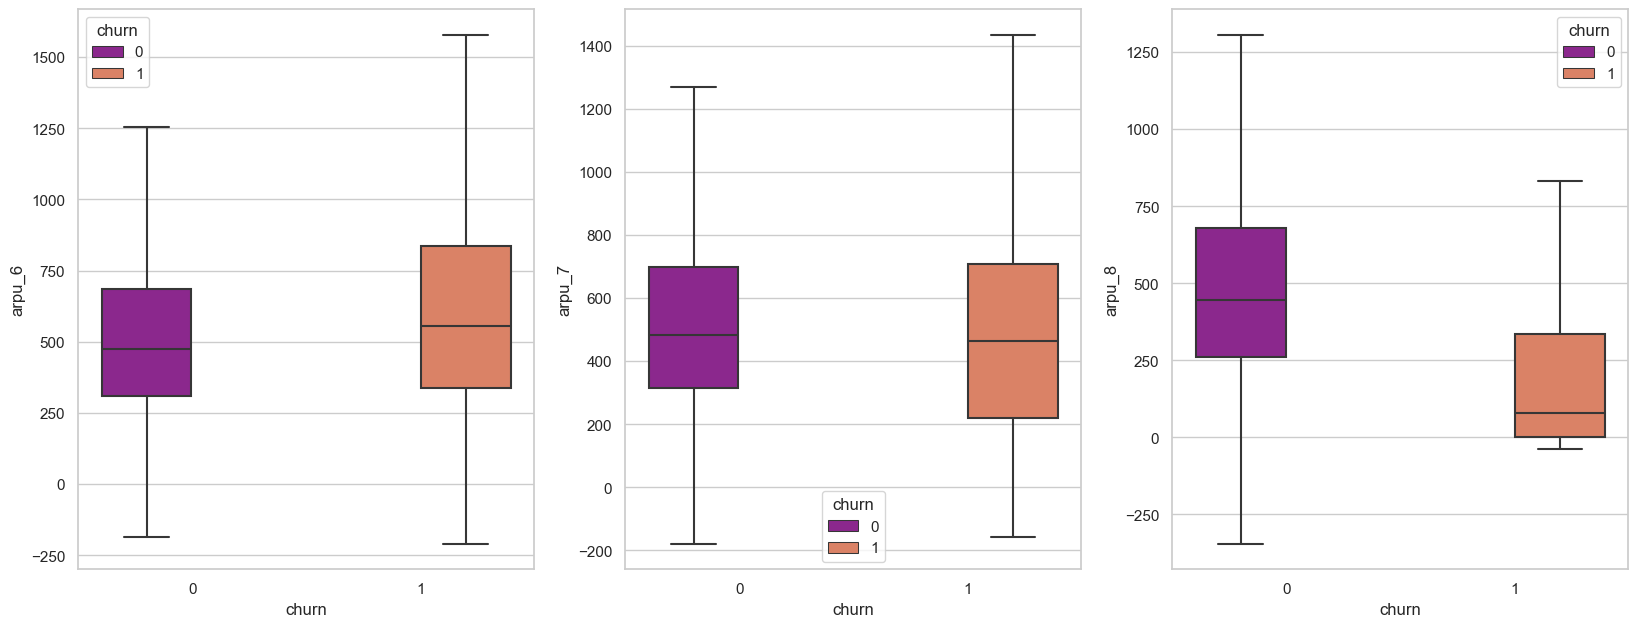

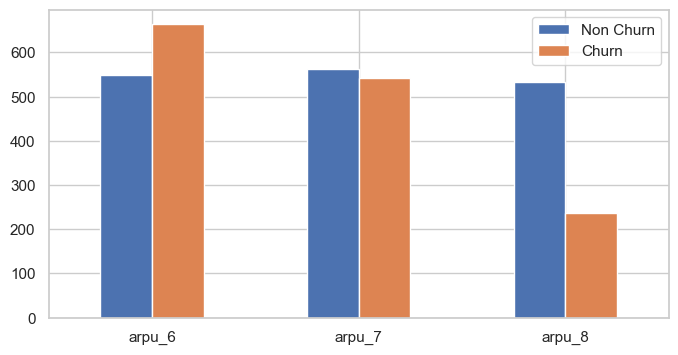

,arpu_6,arpu_7,arpu_8
Non Churn,549.55,562.93,532.87
Churn,663.71,541.15,237.66


In [56]:
arpu_cols = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('arpu_')]
# columns for average revenue per user

plot_box_chart('arpu')
plot_mean_bar_chart(tele_data_high_val_cust, arpu_cols)

 there is adrops for Arpu in 8th month for churned customers

### Voice call - Minutes 

In [57]:
mou_cols = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('mou')]

In [58]:
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mo

In [59]:
meta_df = get_meta_data(tele_data_high_val_cust[mou_cols])
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
isd_ic_mou_8,3.91
loc_ic_t2t_mou_8,3.91
loc_ic_t2m_mou_8,3.91
std_og_t2t_mou_8,3.91
loc_og_t2c_mou_8,3.91
...,...
total_ic_mou_6,0.00
total_ic_mou_7,0.00
total_ic_mou_8,0.00
total_og_mou_6,0.00


In [60]:
tele_data_high_val_cust.loc[:,mou_cols] = tele_data_high_val_cust.loc[:,mou_cols].replace(np.NaN,0) # replaceing null values by 0 for minutes of usage variables

In [61]:
mou_og_cols6 = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('.*_og_.*mou_6',regex=True)]


tele_data_high_val_cust.loc[:,mou_og_cols6].describe()

,roam_og_mou_6,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,loc_og_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,std_og_mou_6,isd_og_mou_6,spl_og_mou_6,total_og_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,26.60,84.57,163.31,6.35,1.58,254.24,165.90,179.44,1.81,347.15,2.17,5.83,610.06
std,116.27,228.96,250.22,22.14,6.31,378.55,403.99,409.14,11.99,608.85,45.89,17.58,691.18
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,4.38,19.21,0.00,0.00,32.26,0.00,0.00,0.00,0.40,0.00,0.00,116.64
50%,0.00,24.36,77.26,0.00,0.00,124.59,2.71,16.36,0.00,45.08,0.00,0.23,410.63
75%,0.00,78.06,209.03,4.23,0.00,332.31,109.56,154.54,0.00,465.29,0.00,5.21,859.03
max,"3,775.11","6,431.33","4,729.74","1,466.03",271.44,"10,643.38","7,366.58","8,314.76",628.56,"8,432.99","5,900.66","1,023.21","10,674.03"


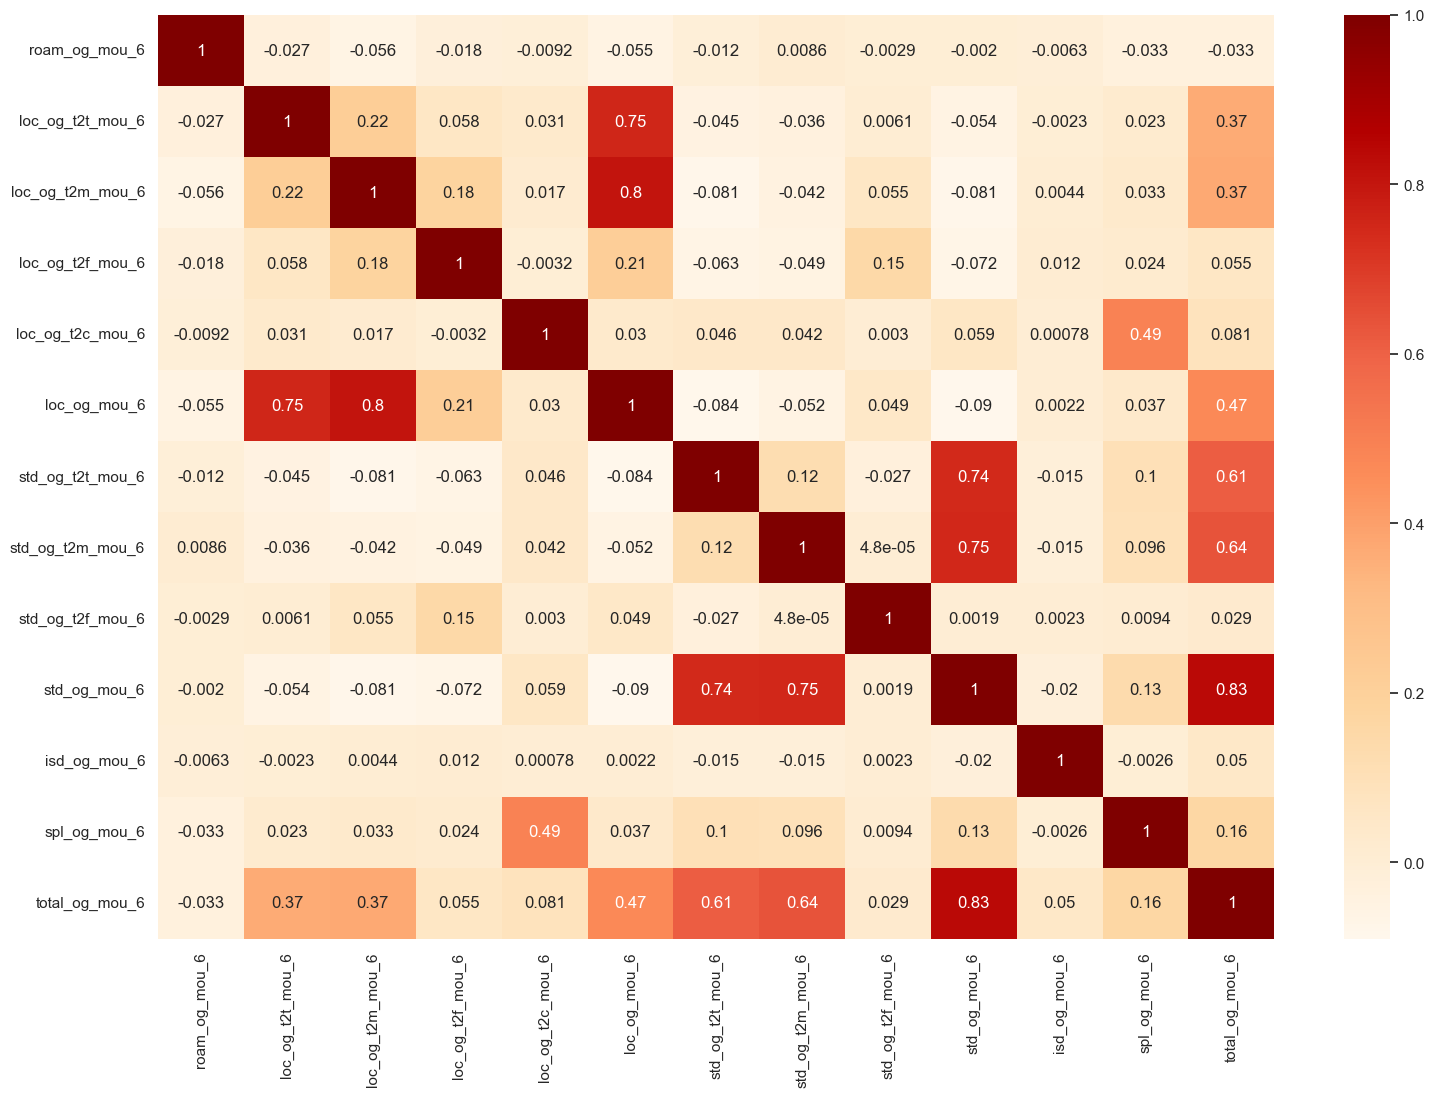

In [62]:
heatmap(18,12,tele_data_high_val_cust.filter(mou_og_cols6))

The total_og_mou_6, std_og_mou_6 and loc_og_mou_6 have strong correlation with other fileds and they needs to be inspected to avoid any multicolinearity issues.

In [63]:
list_total_og_cols = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('total_og_mou|std_og_mou|loc_og_mou',regex=True)]
tele_data_high_val_cust.drop(list_total_og_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_og_cols.tolist()
# dropping columns showing combination of other variables present in dataset

> <span style='color:blue'>Columns dropped - </span>

['loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8']

In [64]:
mou_ic_cols6 = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('.*_ic_.*mou_6',regex=True)]

tele_data_high_val_cust.loc[:,mou_ic_cols6].describe()

,roam_ic_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,loc_ic_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6,std_ic_mou_6,total_ic_mou_6,spl_ic_mou_6,isd_ic_mou_6
count,"29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00","29,953.00"
mean,16.12,65.51,150.47,15.29,231.28,14.90,29.21,2.70,46.81,290.12,0.06,10.80
std,76.34,163.86,219.32,45.79,315.01,77.75,98.28,19.11,137.60,365.74,0.19,76.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,6.10,28.09,0.00,47.91,0.00,0.00,0.00,1.03,72.89,0.00,0.00
50%,0.00,25.08,84.11,1.84,134.56,0.38,5.00,0.00,11.41,183.78,0.00,0.00
75%,0.00,67.48,188.74,11.98,297.26,8.19,23.63,0.11,41.49,372.16,0.00,0.00
max,"2,613.31","6,351.44","4,693.86","1,678.41","7,454.63","5,459.56","4,630.23","1,351.11","5,459.63","7,716.14",19.76,"6,789.41"


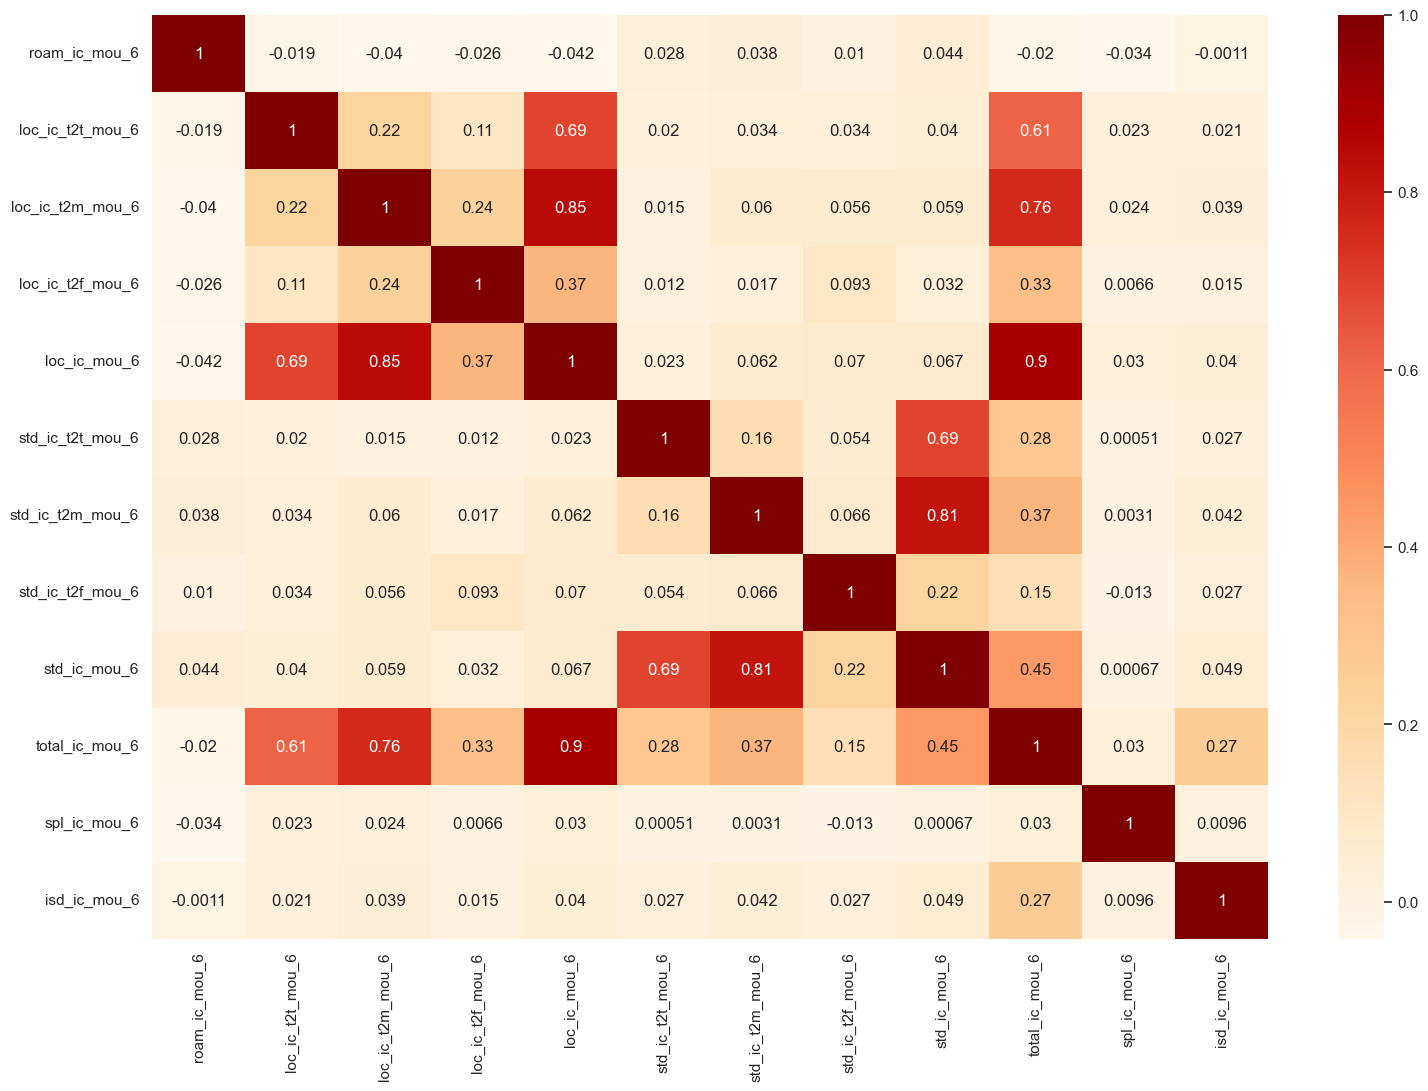

In [65]:
heatmap(18,12,tele_data_high_val_cust.filter(mou_ic_cols6))

 The total_ic_mou_6, std_ic_mou_6 and loc_ic_mou_6 seems to have strong correlation with other fileds and they needs to be inspected to avoid multicolinearity issues.

In [66]:
list_total_ic_cols = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('total_ic_mou|std_ic_mou|loc_ic_mou',regex=True)]
tele_data_high_val_cust.drop(list_total_ic_cols,axis=1,inplace=True)
log("Columns dropped - ")
list_total_ic_cols.tolist()
# There are combination of other variables present in dataset.So we can remove these columns for all months from the data set

> <span style='color:blue'>Columns dropped - </span>

['loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8']

In [67]:
offnet_usage_service_col = tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('offnet.*mou',regex=True)]
# offnet Usage

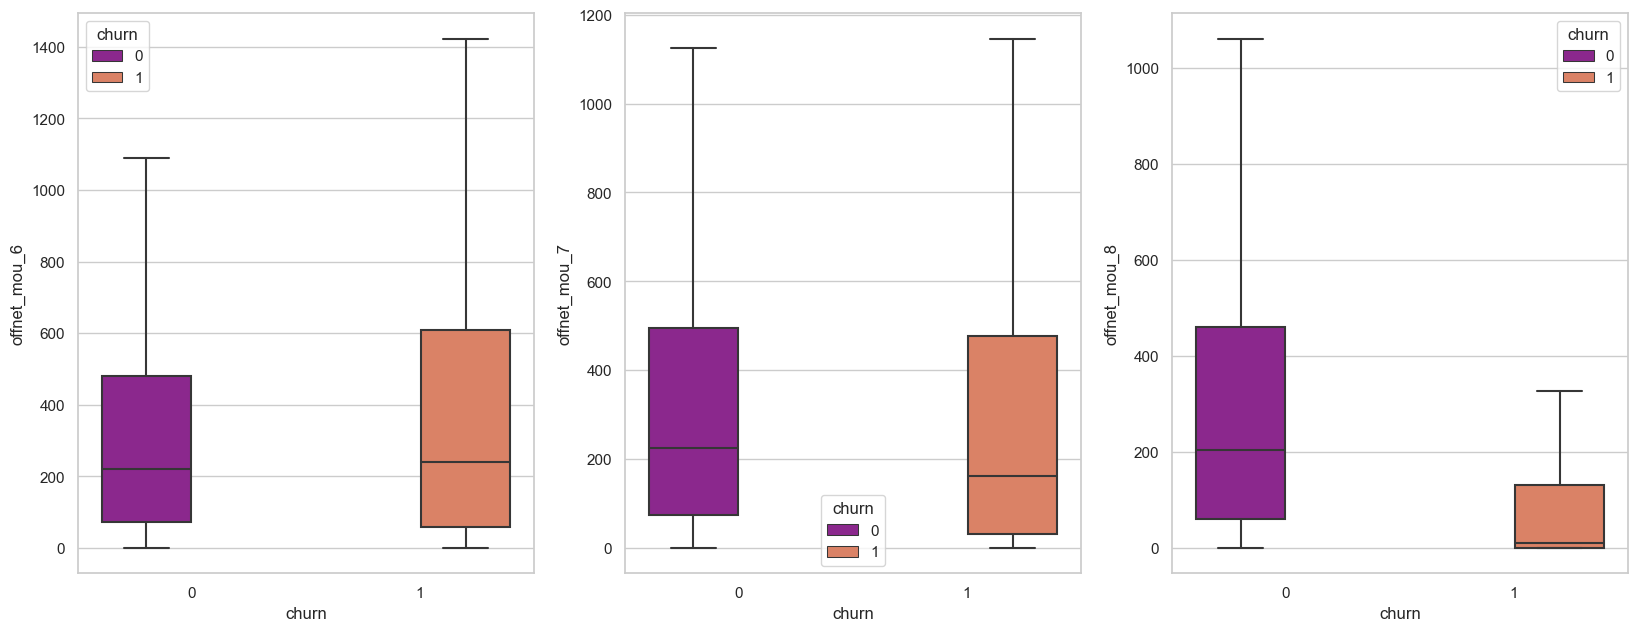

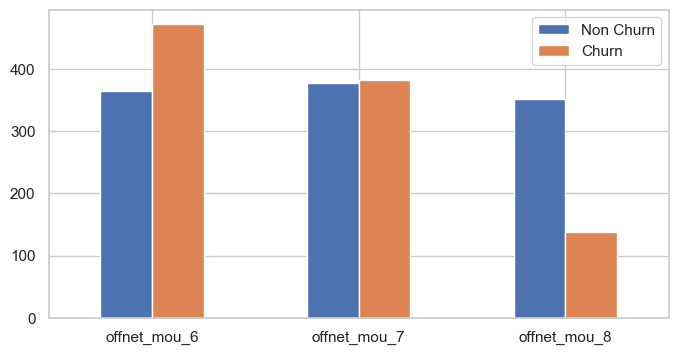

,offnet_mou_6,offnet_mou_7,offnet_mou_8
Non Churn,365.12,377.88,352.50
Churn,471.95,382.28,138.52


In [68]:
plot_box_chart('offnet_mou')
plot_mean_bar_chart(tele_data_high_val_cust, offnet_usage_service_col)

There is a drop for offnet mou services in the 8th month

In [69]:
onnet_usage_service =  tele_data_high_val_cust.columns[tele_data_high_val_cust.columns.str.contains('^onnet.*mou',regex=True)]
# All kind of calls within the same operator network

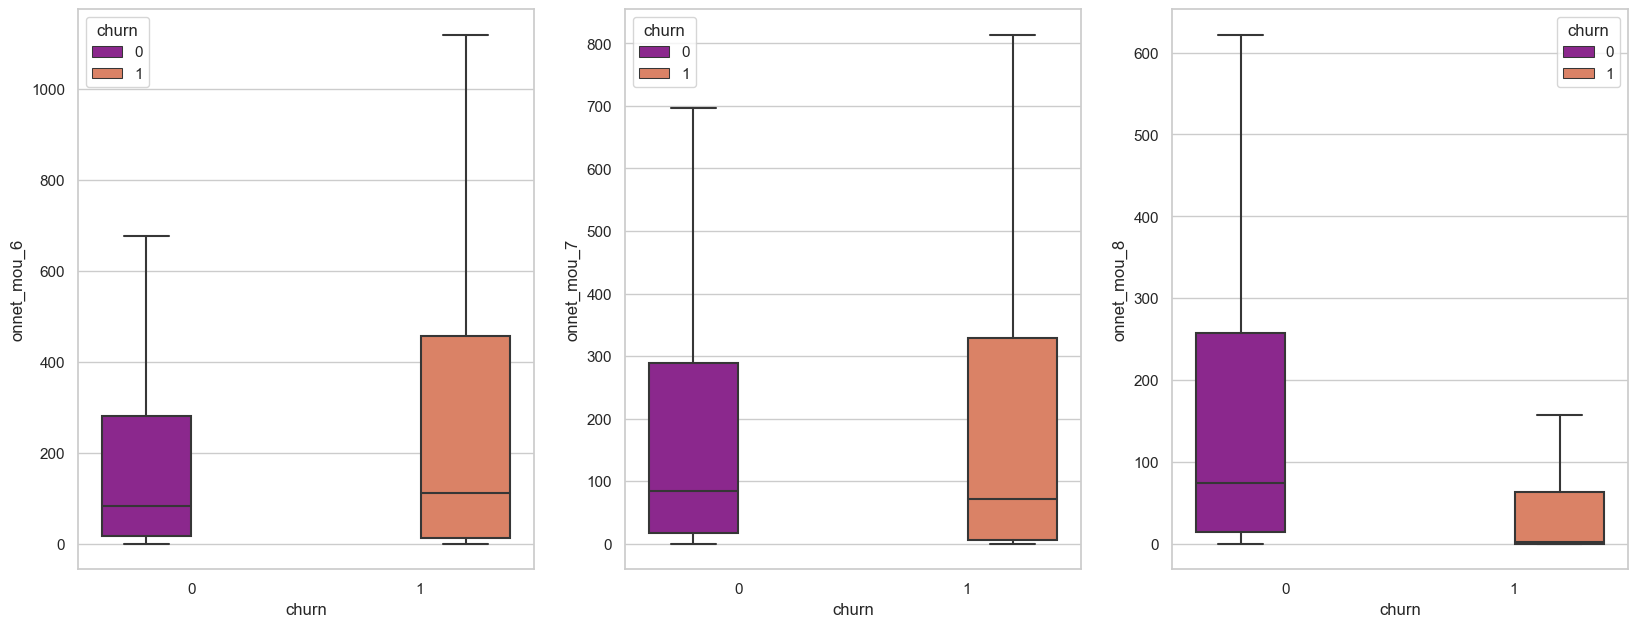

In [70]:
plot_box_chart('onnet_mou')

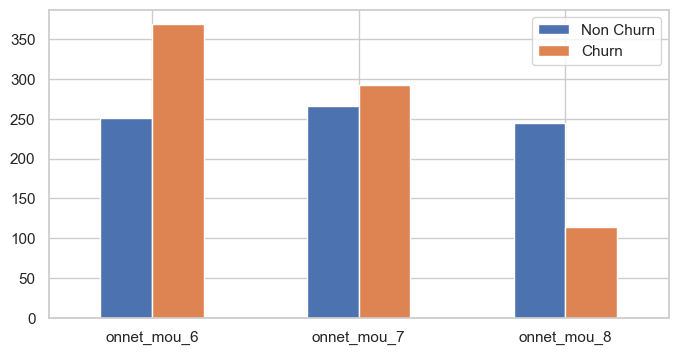

,onnet_mou_6,onnet_mou_7,onnet_mou_8
Non Churn,251.37,265.86,245.03
Churn,368.66,292.85,113.48


In [71]:
plot_mean_bar_chart(tele_data_high_val_cust, onnet_usage_service)


there is a drop in Onnet usage in the 8th month for churned customers

In [72]:
tenure_data = tele_data_high_val_cust.copy()
# Tenure analysis of customers 

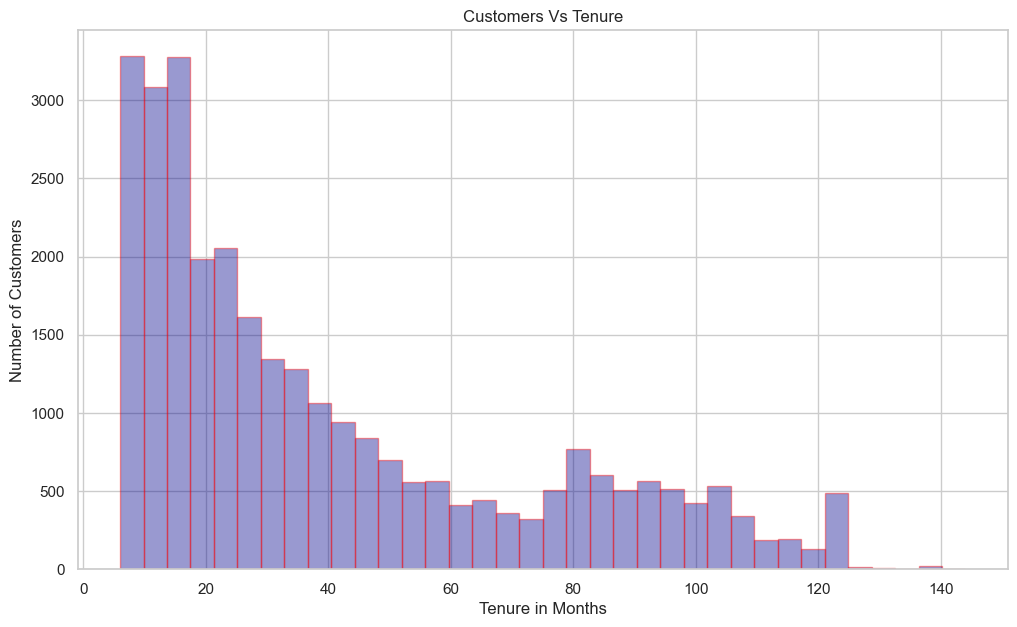

In [73]:
plt.figure(figsize=(12,7))
# Age on network, number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [74]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0     2-5 Yrs    
7     2-5 Yrs    
8     6-12 Months
21    1-2 Yrs    
23    1-2 Yrs    
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

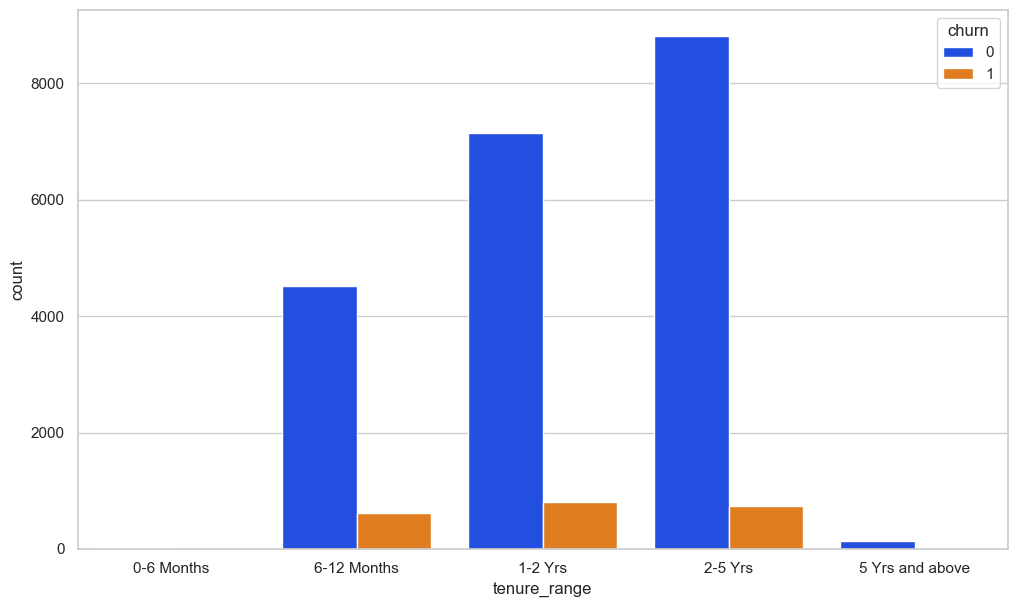

In [75]:
plt.figure(figsize=(12,7))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("bright"))
plt.show()


In [76]:
meta_df = get_meta_data(tele_data_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 30]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]
# checking columns having more than 30% NA values

,Null_Percentage
date_of_last_rech_data_8,46.80
night_pck_user_8,46.80
fb_user_8,46.80
date_of_last_rech_data_6,44.11
night_pck_user_6,44.11
fb_user_6,44.11
date_of_last_rech_data_7,43.12
night_pck_user_7,43.12
fb_user_7,43.12


In [77]:
is_more_30 = meta_df.index
tele_data_high_val_cust.drop(tele_data_high_val_cust[is_more_30],axis=1,inplace=True) # droping column with more than 30% NA

In [78]:
tele_data_high_val_cust.shape

(29953, 124)

In [79]:
meta_df = get_meta_data(tele_data_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 0]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]
# replacing NA

,Null_Percentage
og_others_8,3.91
ic_others_8,3.91
date_of_last_rech_8,1.94
og_others_6,1.81
ic_others_6,1.81
og_others_7,1.79
ic_others_7,1.79
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


In [80]:
tele_data_high_val_cust[meta_df.index].head(5)

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,NaN,NaN,NaN,NaN,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25
21,0.00,0.00,2014-08-31,0.00,0.00,0.00,0.00,2014-07-31,2014-06-30
23,0.00,13.06,2014-08-24,0.00,0.00,0.00,5.35,2014-07-07,2014-06-18


In [81]:
numberic_col = ['og_others_8', 'ic_others_8', 'og_others_6','ic_others_6', 'og_others_7', 'ic_others_7'] # imputing numerics

We can replace NA data with zero as it will not affect out analysis

In [82]:
for i in numberic_col:
    tele_data_high_val_cust.loc[tele_data_high_val_cust[i].isnull(),i]=0

In [83]:
tele_data_high_val_cust[meta_df.index].head(5)

,og_others_8,ic_others_8,date_of_last_rech_8,og_others_6,ic_others_6,og_others_7,ic_others_7,date_of_last_rech_7,date_of_last_rech_6
0,0.00,0.00,2014-08-08,0.00,0.00,0.00,0.00,2014-07-16,2014-06-21
7,0.00,15.14,2014-08-26,0.00,15.74,0.00,15.19,2014-07-25,2014-06-27
8,0.00,0.00,2014-08-30,0.00,0.00,0.00,0.00,2014-07-31,2014-06-25
21,0.00,0.00,2014-08-31,0.00,0.00,0.00,0.00,2014-07-31,2014-06-30
23,0.00,13.06,2014-08-24,0.00,0.00,0.00,5.35,2014-07-07,2014-06-18


In [84]:
meta_df = get_meta_data(tele_data_high_val_cust)
meta_df = meta_df[meta_df["Null_Percentage"] > 0]
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
date_of_last_rech_8,1.94
date_of_last_rech_7,0.33
date_of_last_rech_6,0.24


In [85]:
tele_data_final = tele_data_high_val_cust.copy()
print(tele_data_final.shape)
tele_data_final.head(5)

(29953, 124)


,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,...,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,total_avg_rech_amnt_6_7_GPhase,churn
0,7000842753,197.38,214.82,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,...,3,2,362,252,252,252,252,252,2014-06-21,2014-07-16,2014-08-08,252,252,252,1.00,1.00,1.00,252.00,252.00,252.00,252.00,252.00,252.00,30.13,1.32,5.75,83.57,150.76,109.61,0,0,0,0,0,0,1,1,1,0,0,0,968,30.40,0.00,101.20,252.00,252.00,252.00,559.00,1
7,7000701601,"1,069.18","1,349.85","3,171.48",57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.00,0.00,0.00,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.00,0.18,10.01,4.50,0.00,6.50,0.00,0.00,0.00,58.14,32.26,27.31,217.56,...,5,7,1580,790,3638,1580,790,1580,2014-06-27,2014-07-25,2014-08-26,0,0,779,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,802,57.74,19.38,18.74,0.00,0.00,0.00,"1,185.00",1
8,7001524846,378.72,492.22,137.36,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.00,0.00,7.15,116.56,133.43,22.58,13.69,10.04,75.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.23,0.00,0.00,0.00,23.84,9.84,0.31,57.58,...,21,14,437,601,120,90,154,30,2014-06-25,2014-07-31,2014-08-30,50,0,10,0.00,2.00,3.00,0.00,154.00,23.00,0.00,177.00,69.00,0.00,356.00,0.03,0.00,750.95,11.94,0,1,0,0,1,3,0,0,0,0,0,0,315,21.03,910.65,122.16,0.00,354.00,207.00,696.00,0
21,7002124215,514.45,597.75,637.76,102.41,132.11,85.14,757.93,896.68,983.39,0.00,0.00,0.00,0.00,0.00,0.00,4.48,6.16,23.34,91.81,87.93,104.81,0.75,0.00,1.58,0.00,0.00,0.00,97.93,125.94,61.79,665.36,808.74,876.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.48,10.19,19.54,118.23,...,26,27,600,680,718,50,50,50,2014-06-30,2014-07-31,2014-08-31,30,20,50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0,0,0,0,720,0.00,0.00,0.00,0.00,0.00,0.00,640.00,0
23,7000887461,74.35,193.90,366.97,48.96,50.66,33.58,85.41,89.36,205.89,0.00,0.00,0.00,0.00,0.00,0.00,48.96,50.66,33.58,82.94,83.01,148.56,0.00,0.00,0.00,0.00,0.00,17.71,0.00,0.00,0.00,2.36,6.35,39.61,0.00,0.00,0.00,0.00,0.01,0.00,0.10,0.00,17.71,0.00,0.00,0.00,20.71,61.04,76.64,95.91,...,5,4,0,454,439,0,179,179,2014-06-18,2014-07-07,2014-08-24,0,179,0,0.00,2.00,2.00,0.00,179.00,179.00,0.00,356.00,270.00,0.00

In [86]:
tele_data_final.drop(["total_avg_rech_amnt_6_7_GPhase"],axis=1,inplace=True)
tele_data_final.drop(tele_data_high_val_cust.filter(regex='date_').columns,axis=1,inplace=True)
print (tele_data_final.shape)

col_list = tele_data_final.filter(regex='_6|_7').columns.str[:-2]
for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    tele_data_final[avg_col_name] = (tele_data_final[col_6]  + tele_data_final[col_7])/ 2

(29953, 120)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2t_mou
loc_og_t2m_mou
loc_og_t2f_mou
loc_og_t2c_mou
std_og_t2t_mou
std_og_t2m_mou
std_og_t2f_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_t2t_mou
loc_ic_t2m_mou
loc_ic_t2f_mou
std_ic_t2t_mou
std_ic_t2m_mou
std_ic_t2f_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
total_rech_amt
max_rech_amt
last_day_rch_amt
total_rech_data
max_rech_data
av_rech_amt_data
vol_2g_mb
vol_3g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g
total_rech_amt_data


In [87]:
col_list_to_drop = tele_data_final.filter(regex='_6|_7')
tele_data_final.drop(col_list_to_drop,axis=1,inplace=True)
print (tele_data_final.shape)

(29953, 81)


In [88]:
tele_data_final.head(5)

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,4.13,1.15,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,252,1.00,252.00,252.00,5.75,109.61,0,0,1,0,968,30.40,252.00,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,307.00,252.00,252.00,1.00,252.00,252.00,15.72,117.16,0.00,0.00,1.00,0.00,50.60,252.00
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,12.01,49.14,16.68,10.01,6.50,0.00,27.31,121.19,39.53,30.39,141.33,22.21,0.00,31.59,15.14,7,3638,1580,779,0.00,0.00,0.00,0.00,0.00,0,0,0,0,802,57.74,0.00,1,"1,209.51",56.26,510.29,24.86,18.16,41.38,378.00,58.64,0.00,13.79,40.83,13.37,0.09,2.25,0.00,45.20,219.53,126.81,24.36,109.22,43.22,0.10,8.29,15.46,5.00,"1,185.00","1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,0.00
8,7001524846,137.36,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,22.58,75.69,0.00,0.00,10.23,0.00,0.31,15.48,0.00,0.10,0.65,0.00,0.00,0.00,0.00,14,120,30,10,3.00,23.00,69.00,0.03,11.94,0,3,0,0,315,21.03,207.00,0,435.47,382.36,87.64,0.00,0.00,257.36,75.77,0.00,0.00,125.00,11.86,0.00,0.00,0.00,0.00,16.84,35.78,0.00,0.29,13.25,0.00,0.00,0.00,0.00,20.00,519.00,122.00,25.00,1.00,77.00,88.50,178.00,375.48,0.50,0.50,0.00,0.00,516.40,177.00
21,7002124215,637.76,85.14,983.39,0.00,0.00,23.34,104.81,1.58,0.00,61.79,876.99,0.00,0.00,0.00,0.00,19.54,129.16,10.39,0.18,101.74,0.00,0.00,0.00,0.00,27,718,50,50,0.00,0.00,0.00,0.00,0.00,0,0,0,0,720,0.00,0.00,0,556.10,117.26,827.30,0.00,0.00,5.32,89.87,0.38,0.00,111.94,737.05,0.00,0.00,0.00,0.00,6.33,96.43,3.73,10.02,52.96,0.00,0.00,0.00,0.00,24.00,640.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,33.58,148.56,0.00,17.71,0.00,39.61,0.00,0.00,17.71,0.00,76.64,146.84,0.71,13.38,43.91,0.00,0.00,3.74,13.06,4,439,179,0,2.00,179.00,270.00,0.01,"1,009.92",0,0,1,1,604,40.45,540.00,0,134.12,49.81,87.38,0.00,0.00,49.81,82.97,0.00,0.00,0.00,4.35,0.00,0.01,0.05,0.00,40.88,104.63,0.00,0.26,8.66,0.00,0.00,14.12,2.67,4.00,227.00,89.50,89.50,1.00,89.50,178.00,0.24,299.55,0.00,0.00,1.00,0.00,25.93,356.00


### Train-Test Split


In [89]:
# Import library
from sklearn.model_selection import train_test_split


In [90]:
# Putting feature variables into X
X = tele_data_final.drop(['mobile_number','churn'], axis=1)

In [91]:
tele_data_final['churn']

0        1
7        1
8        0
21       0
23       0
        ..
99981    0
99984    0
99986    0
99988    0
99997    0
Name: churn, Length: 29953, dtype: int64

In [92]:
# Putting target variable to y
y = tele_data_final['churn']

In [93]:
# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

### Dealing with data imbalance
We are creating synthetic samples by doing upsampling using SMOTE(Synthetic Minority Oversampling Technique).

In [94]:
# Imporing SMOTE
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [95]:
# Instantiate SMOTE
sm = SMOTE(random_state=27)

In [96]:
# Fittign SMOTE to the train set
X_train, y_train = sm.fit_resample(X_train, y_train)


### Feature Scaling


In [97]:
# Standardization method
from sklearn.preprocessing import StandardScaler

In [98]:
# Instantiate the Scaler
scaler = StandardScaler()

In [99]:
# List of the numeric columns
cols_scale = X_train.columns.to_list()

In [100]:
### Fit the data into scaler and transform
X_train[cols_scale] = scaler.fit_transform(X_train[cols_scale])


In [101]:
X_train.head()


,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
0,1.87,-0.44,-0.10,-0.18,-0.23,-0.28,-0.04,-0.24,-0.22,-0.33,-0.02,-0.11,-0.04,-0.28,-0.01,-0.32,-0.34,-0.26,-0.16,-0.21,-0.11,-0.19,0.03,-0.08,1.12,1.85,3.24,4.53,1.65,6.23,5.88,0.99,3.84,6.12,-0.32,1.77,2.20,-0.64,6.48,4.12,-0.32,-0.62,-0.49,-0.22,-0.28,-0.37,-0.29,-0.30,-0.26,-0.49,-0.33,-0.15,-0.07,-0.41,-0.20,-0.41,-0.42,-0.32,-0.23,-0.22,-0.15,-0.40,-0.19,-0.10,0.28,-0.34,-0.40,-0.67,-0.23,0.09,0.14,-0.33,0.97,2.67,-0.46,-0.40,-0.23,1.91,-0.13
1,1.44,-0.34,1.94,2.70,8.66,-0.28,-0.50,-0.24,-0.22,-0.33,-0.34,-0.11,-0.04,-0.28,-0.01,-0.32,-0.52,-0.26,-0.17,-0.22,-0.11,-0.19,-0.14,-0.08,2.19,1.64,0.06,0.50,-0.44,-0.50,-0.48,-0.27,-0.31,-0.27,-0.32,-0.27,-0.15,2.87,-0.32,-0.23,1.11,-0.54,1.72,3.79,10.16,-0.37,-0.64,-0.30,-0.26,-0.49,-0.50,-0.15,-0.07,-0.41,-0.20,-0.41,-0.67,-0.32,-0.23,-0.35,-0.15,-0.40,-0.19,-0.10,0.40,1.22,-0.18,0.38,-0.62,-0.69,-0.71,-0.40,-0.41,-0.41,-0.46,-0.40,-0.23,-0.40,-0.39
2,0.39,-0.30,0.44,-0.10,-0.05,-0.08,1.46,-0.08,-0.22,-0.28,-0.32,0.87,-0.04,0.30,-0.01,-0.08,0.60,0.30,-0.17,-0.22,-0.06,-0.19,-0.14,-0.04,-0.41,0.04,0.78,-0.30,-0.44,-0.50,-0.48,-0.27,-0.31,-0.27,-0.32,-0.27,-0.15,-0.80,-0.32,-0.23,-0.19,-0.52,-0.14,-0.19,-0.24,-0.17,0.72,0.33,-0.26,-0.46,-0.48,1.94,-0.07,-0.41,-0.20,-0.28,0.54,0.36,0.07,-0.17,1.05,-0.40,-0.19,-0.10,-0.96,0.00,0.92,1.67,-0.62,-0.69,-0.71,-0.40,-0.41,-0.41,-0.46,-0.40,-0.23,-0.40,-0.39
3,0.48,-0.09,-0.41,-0.10,-0.13,-0.13,-0.18,-0.24,-0.06,-0.03,-0.33,-0.11,-0.04,-0.18,-0.01,-0.16,0.75,0.10,-0.04,-0.22,-0.11,2.94,-0.13,-0.08,2.66,0.46,-0.55,-0.27,1.24,-0.24,0.13,-0.07,-0.31,-0.27,0.69,-0.27,2.20,2.15,-0.32,0.10,0.35,-0.15,-0.67,0.27,0.62,-0.24,-0.44,-0.30,-0.26,-0.27,-0.49,-0.15,-0.07,-0.41,-0.20,-0.37,-0.48,-0.32,-0.07,-0.30,-0.15,-0.40,-0.19,-0.10,1.06,0.28,-0.39,-0.49,0.36,-0.07,-0.10,-0.32,-0.41,-0.41,0.66,-0.40,-0.23,-0.40,-0.16
4,-0.34,-0.44,-0.57,-0.18,-0.23,-0.28,-0.50,-0.24,-0.22,-0.33,-0.34,-0.11,-0.04,-0.28,-0.01,-0.31,-0.52,-0.26,-0.17,-0.22,-0.11,1.19,-0.08,0.10,-0.53,-0.30,0.79,-0.50,-0.02,2.09,1.04,-0.24,1.20,-0.27,-0.32,1.77,-0.15,-0.80,0.98,-0.03,-0.58,-0.62,-0.77,-0.22,-0.28,-0.37,-0.64,-0.30,-0.26,-0.49,-0.50,-0.15,-0.07,-0.08,-0.20,-0.40,-0.67,-0.32,0.31,0.72,-0.15,-0.00,0.35,-0.09,-1.02,-0.82,0.60,1.46,-0.03,1.85,1.60,-0.38,1.32,-0.41,-0.46,2.63,-0.23,0.17,0.19


Scaling the test set
We don't fit scaler on the test set. We only transform the test set.

In [102]:
# Transform the test set
X_test[cols_scale] = scaler.transform(X_test[cols_scale])
X_test.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,std_og_t2t_mou_8,std_og_t2m_mou_8,std_og_t2f_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_t2t_mou_8,loc_ic_t2m_mou_8,loc_ic_t2f_mou_8,std_ic_t2t_mou_8,std_ic_t2m_mou_8,std_ic_t2f_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,total_rech_amt_8,max_rech_amt_8,last_day_rch_amt_8,total_rech_data_8,max_rech_data_8,av_rech_amt_data_8,vol_2g_mb_8,vol_3g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,total_rech_amt_data_8,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2t_mou_av67,avg_loc_og_t2m_mou_av67,avg_loc_og_t2f_mou_av67,avg_loc_og_t2c_mou_av67,avg_std_og_t2t_mou_av67,avg_std_og_t2m_mou_av67,avg_std_og_t2f_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_t2t_mou_av67,avg_loc_ic_t2m_mou_av67,avg_loc_ic_t2f_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2m_mou_av67,avg_std_ic_t2f_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_total_rech_amt_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_total_rech_data_av67,avg_max_rech_data_av67,avg_av_rech_amt_data_av67,avg_vol_2g_mb_av67,avg_vol_3g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,avg_total_rech_amt_data_av67
48388,12.43,-0.00,1.94,1.99,1.71,-0.22,1.16,0.30,1.61,0.09,1.13,-0.11,-0.04,-0.28,-0.01,-0.18,0.65,-0.19,2.32,4.39,-0.11,-0.19,-0.14,-0.06,0.53,9.93,5.63,1.42,-0.44,-0.50,-0.48,-0.27,-0.31,-0.27,-0.32,-0.27,-0.15,-0.90,-0.32,-0.23,15.75,-0.25,0.78,6.93,5.18,-0.37,-0.11,-0.28,-0.17,-0.38,-0.24,-0.15,-0.07,-0.41,-0.20,-0.41,-0.19,-0.29,0.81,0.94,-0.13,-0.40,-0.19,-0.10,-0.19,12.32,5.93,6.26,-0.62,-0.69,-0.71,-0.40,-0.41,-0.41,-0.46,-0.40,-0.23,-0.40,-0.39
29754,0.52,-0.39,0.14,-0.18,-0.23,-0.16,1.00,-0.18,-0.22,-0.33,-0.34,-0.11,0.15,-0.07,-0.01,-0.17,2.76,0.95,-0.17,-0.21,-0.11,-0.19,-0.14,-0.08,-0.06,0.64,0.96,-0.50,-0.02,1.34,0.60,-0.27,1.29,-0.27,-0.32,1.77,-0.15,3.32,-0.32,-0.09,-0.46,-0.59,-0.17,-0.22,-0.28,-0.28,0.78,0.55,-0.26,-0.48,-0.50,-0.15,-0.07,-0.41,-0.20,-0.22,1.83,1.61,-0.14,-0.35,0.46,-0.40,0.52,-0.10,-0.67,-0.43,0.10,0.24,-0.23,0.87,0.23,-0.40,0.77,2.67,-0.46,-0.40,-0.23,-0.40,-0.25
50131,0.27,-0.17,-0.38,-0.11,-0.22,0.31,-0.09,-0.24,-0.22,-0.32,-0.34,-0.11,-0.04,-0.28,-0.01,1.09,0.69,-0.20,0.13,0.02,0.06,-0.19,-0.14,-0.08,1.60,0.26,-0.43,-0.31,2.07,-0.24,0.43,-0.10,0.86,-0.27,2.71,-0.27,-0.15,-0.64,1.01,0.51,-0.42,-0.53,-0.71,-0.17,-0.28,-0.18,-0.50,-0.30,-0.10,-0.47,-0.49,-0.15,-0.07,-0.34,-0.20,0.35,0.15,-0.30,-0.12,-0.28,0.21,-0.40,-0.19,-0.10,1.17,-0.41,-0.82,-0.61,3.48,-0.43,0.79,0.20,0.80,-0.41,3.80,-0.40,0.84,0.97,2.58
66630,0.05,-0.42,0.90,-0.18,-0.23,-0.23,-0.07,-0.24,-0.17,-0.33,1.08,-0.11,-0.04,2.50,-0.01,-0.22,0.44,-0.00,0.96,8.40,-0.04,-0.19,-0.14,-0.05,1.01,0.04,-0.43,-0.11,-0.02,-0.26,-0.34,-0.26,-0.31,-0.27,0.18,-0.27,-0.15,-0.62,-0.32,-0.21,-0.22,-0.61,0.47,-0.22,-0.28,-0.35,-0.25,-0.30,-0.26,-0.48,0.70,-0.15,-0.07,-0.40,-0.20,-0.21,0.37,-0.24,0.01,9.58,-0.02,3.25,-0.19,0.08,1.11,-0.24,-0.63,-0.58,-0.62,-0.69,-0.71,-0.40,-0.41,-0.41,-0.46,-0.40,-0.23,-0.40,-0.39
91920,0.47,0.27,0.31,-0.18,-0.23,1.35,1.36,-0.24,-0.22,-0.33,-0.30,-0.11,-0.04,-0.01,-0.01,0.80,0.49,-0.25,-0.17,-0.19,-0.11,1.06,0.09,0.07,0.06,0.21,0.06,-0.50,-0.44,-0.50,-0.48,-0.27,-0.31,-0.27,-0.32,-0.27,-0.15,-0.33,-0.32,-0.23,1.10,1.29,0.55,-0.22,-0.28,3.87,2.21,-0.30,-0.26,-0.26,-0.34,-0.15,-0.07,0.06,0.90,3.61,1.19,-0.14,-0.23,-0.21,-0.15,0.65,0.47,0.26,0.22,1.13,-0.28,0.24,-0.62,-0.69,-0.71,-0.40,-0.41,-0.41,-0.46,-0.40,-0.23,-0.40,-0.39


## Modelling 

### Principal Component Analysi (PCA)

In [103]:
#Import PCA
from sklearn.decomposition import PCA

In [104]:
# Instantiate PCA
pca = PCA(random_state=42)

In [105]:
# Fit train set on PCA
pca.fit(X_train)

PCA(random_state=42)

In [106]:
# Principal components
pca.components_

array([[ 1.58171017e-01, -8.27161119e-03,  4.43131702e-02, ...,
         7.49955084e-02,  2.11121333e-01,  1.72227236e-01],
       [ 2.60348172e-01,  1.76436325e-01,  2.30508743e-01, ...,
        -9.60446355e-02, -5.32962625e-02, -1.50232433e-01],
       [ 1.11743324e-01,  1.46902304e-01,  1.22357607e-01, ...,
         1.60074125e-01, -6.92654015e-02,  1.90770848e-01],
       ...,
       [-2.96301478e-03, -3.26450162e-01, -3.41682533e-01, ...,
         2.59551950e-05,  3.63845967e-04,  2.95067268e-04],
       [-2.23390406e-03, -3.71719053e-01, -3.82554307e-01, ...,
        -4.58175976e-06, -1.94447235e-04, -2.81610134e-04],
       [-2.77198256e-16, -2.41705714e-15, -2.02210860e-15, ...,
         2.61622457e-01, -4.15392231e-17,  1.70060331e-16]])

In [107]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.1057715  0.19892892 0.2587089  0.30660543 0.34546782 0.38015907
 0.41117525 0.44074632 0.46927407 0.49558719 0.52126027 0.54492993
 0.56742448 0.5880629  0.60840052 0.62729622 0.64492269 0.66234589
 0.67912478 0.69473681 0.71016547 0.72493063 0.73932305 0.75319123
 0.76647636 0.77866551 0.79052362 0.8014429  0.81174025 0.82187937
 0.83173985 0.84116224 0.85045862 0.85938006 0.86777309 0.87590727
 0.88390647 0.8916849  0.89885276 0.90583569 0.9118184  0.91726446
 0.92251913 0.92758522 0.93226379 0.93648235 0.9405766  0.94454392
 0.9482994  0.95196177 0.95546297 0.95886191 0.9620937  0.96526729
 0.96828259 0.97127068 0.97413823 0.97689236 0.97955739 0.98210801
 0.98448725 0.9868121  0.98903031 0.99111711 0.99297639 0.99479928
 0.99603988 0.9972388  0.99810071 0.99877696 0.99922707 0.99954298
 0.99976407 0.99989895 0.99995689 0.99999711 0.99999924 1.
 1.        ]


Text(0, 0.5, 'Cumulative Variance')

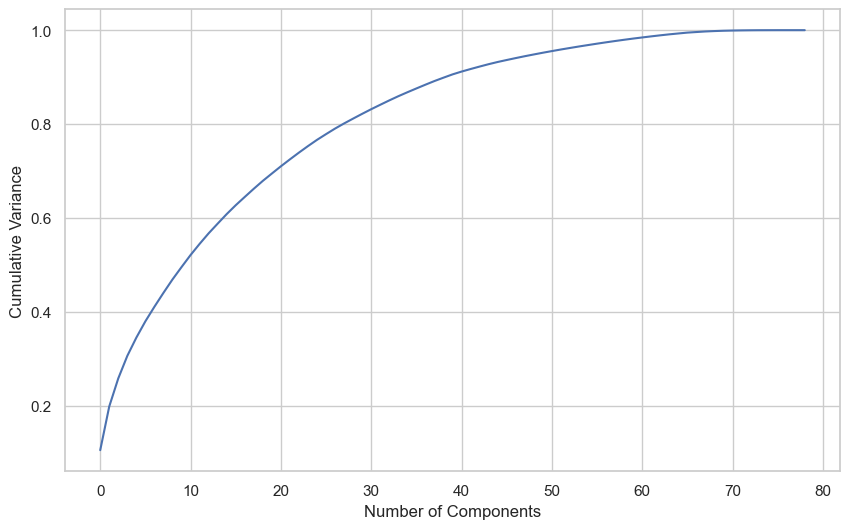

In [108]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

We can see that 60 components explain amost more than 90% variance of the data. So, we will perform PCA with 60 components.

Performing PCA with 60 components

In [109]:
# Importing incremental PCA
from sklearn.decomposition import IncrementalPCA

In [110]:
# Instantiate PCA with 60 components
pca_final = IncrementalPCA(n_components=60)

In [111]:
# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train)

### Applying transformation on the test set
We are only doing Transform in the test set not the Fit-Transform. Because the Fitting is already done on the train set. So, we just have to do the transformation with the already fitted data on the train set.

In [112]:
X_test_pca = pca_final.transform(X_test)

#### Emphasize Sensitivity/Recall than Accuracy
We are more focused on higher Sensitivity/Recall score than the accuracy.

Beacuse we need to care more about churn cases than the not churn cases. The main goal is to reatin the customers, who have the possiblity to churn. There should not be a problem, if we consider few not churn customers as churn customers and provide them some incentives for retaining them. Hence, the sensitivity score is more important here.



### Logistic regression with PCA


In [113]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

In [114]:
# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### Tuning` hyperparameter C
C is the the inverse of regularization strength in Logistic Regression. Higher values of C correspond to less regularization.

In [115]:
# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [116]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [117]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.24,0.01,0.00,0.00,0.01,{'C': 0.01},0.87,0.88,0.86,0.86,0.86,0.87,0.01,6,0.87,0.86,0.87,0.86,0.86,0.87,0.00
1,0.32,0.00,0.00,0.00,0.10,{'C': 0.1},0.87,0.87,0.86,0.86,0.86,0.87,0.01,2,0.87,0.86,0.87,0.87,0.86,0.87,0.00
2,0.35,0.03,0.00,0.00,1,{'C': 1},0.87,0.87,0.86,0.86,0.86,0.87,0.01,1,0.87,0.87,0.87,0.87,0.86,0.87,0.00
3,0.39,0.05,0.00,0.00,10,{'C': 10},0.87,0.87,0.86,0.86,0.86,0.87,0.01,3,0.87,0.87,0.87,0.87,0.86,0.87,0.00
4,0.35,0.07,0.00,0.00,100,{'C': 100},0.87,0.87,0.86,0.86,0.86,0.87,0.01,4,0.87,0.87,0.87,0.87,0.86,0.87,0.00
5,0.37,0.03,0.00,0.00,1000,{'C': 1000},0.87,0.87,0.86,0.86,0.86,0.87,0.01,4,0.87,0.87,0.87,0.87,0.86,0.87,0.00


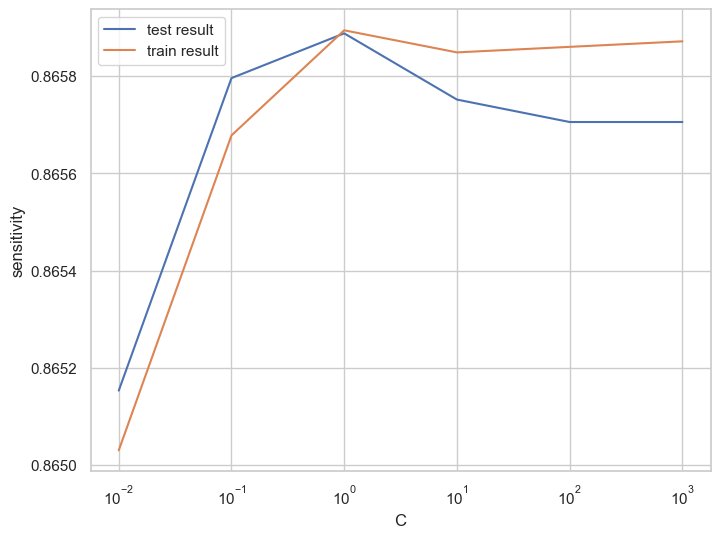

In [118]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [119]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8658879661662805 at C = 1


## Logistic regression with optimal C


In [120]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C)
# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_pca, y_train)

### Prediction on the train set


In [121]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_pca)


In [122]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[17936  4060]
 [ 2956 19040]]


In [123]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [124]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8405164575377342
Sensitivity:- 0.8656119294417167
Specificity:- 0.8154209856337515


Prediction on the test set


In [125]:
# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_pca)


In [126]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4483 1041]
 [  75  392]]


In [127]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [128]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8137205808713069
Sensitivity:- 0.8394004282655246
Specificity:- 0.8115496017378712


#### Model summary

** Train set
  * Accuracy = 0.84
  * Sensitivity = 0.86
  * Specificity = 0.81

**Test set
  * Accuracy = 0.81
  * Sensitivity = 0.83
  * Specificity = 0.81 
  
Overall, the model is performing well in the test set, what it had learnt from the train set.

## Support Vector Machine(SVM) with PCA


In [130]:
# Importing SVC
from sklearn.svm import SVC

Hyperparameter tuning C:- Regularization parameter.

gamma:- Handles non linear classifications.

In [131]:
from sklearn import svm

In [132]:
# specify range of hyperparameters

hyper_params = {'gamma': [0.1,1, 10, 100],
                     'C': [1, 10, 100, 1000]}


# specify model with RBF kernel
model = svm.SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = 3, 
                        verbose = 1,
                        return_train_score=True)      

In [133]:
# fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

In [135]:
from sklearn.model_selection import GridSearchCV
cv_results = pd.DataFrame(classifier.cv_results_)
cv_results

NameError: name 'classifier' is not defined

Plotting the accuracy with various C and gamma values


KeyError: 'param_gamma'

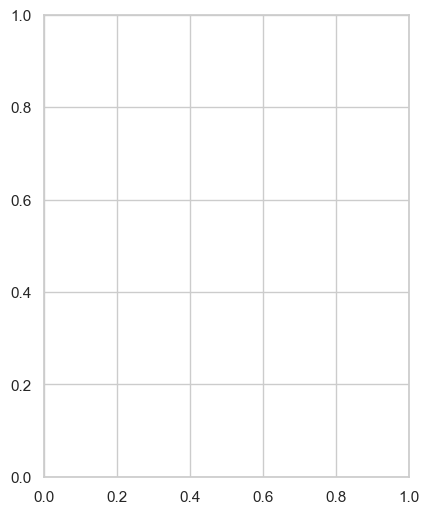

In [136]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.80, 1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


In [137]:
# Printing the best score 
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

Build the model with optimal hyperparameters

In [138]:
# Building the model with optimal hyperparameters
svm_pca_model = SVC(C=100, gamma=0.0001, kernel="rbf")

svm_pca_model.fit(X_train_pca, y_train)

SVC(C=100, gamma=0.0001)

## Prediction on the train set


In [139]:
# Predictions on the train set
y_train_pred = svm_pca_model.predict(X_train_pca)


In [141]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[17936  4060]
 [ 2956 19040]]


In [142]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [143]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))


Accuracy:- 0.8405164575377342
Sensitivity:- 0.8656119294417167
Specificity:- 0.8154209856337515


Prediction on the test set`

In [144]:
# Prediction on the test set
y_test_pred = svm_pca_model.predict(X_test_pca)

In [145]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4678  846]
 [  84  383]]


In [146]:
# Prediction on the test set
y_test_pred = svm_pca_model.predict(X_test_pca)

In [147]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4678  846]
 [  84  383]]


In [148]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [149]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8447671507260891
Sensitivity:- 0.8201284796573876
Specificity:- 0.8468501086169442


#### Model summary

** Train set
  * Accuracy = 0.85
  * Sensitivity = 0.85
  * Specificity = 0.84

** Test set
  * Accuracy = 0.84
  * Sensitivity = 0.82
  * Specificity = 0.84

Overall, the model is performing well in the test set, what it had learnt from the train set.


## Decision tree with PCA


In [150]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

## Hyperparameter tuning


In [151]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_pca,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [151]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.24,0.00,0.00,0.00,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 50}",0.79,0.84,0.76,0.82,0.83,0.81,0.03,7
1,1.24,0.00,0.00,0.00,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_samples_split': 100}",0.79,0.84,0.76,0.82,0.83,0.81,0.03,7
2,1.23,0.00,0.00,0.00,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 50}",0.80,0.84,0.76,0.82,0.84,0.81,0.03,5
3,1.24,0.00,0.00,0.00,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 100}",0.80,0.84,0.76,0.82,0.84,0.81,0.03,5
4,2.09,0.02,0.00,0.00,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}",0.82,0.87,0.84,0.85,0.86,0.85,0.02,2
5,2.09,0.02,0.00,0.00,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 100}",0.82,0.87,0.84,0.85,0.86,0.85,0.02,1
6,1.98,0.01,0.00,0.00,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 50}",0.81,0.85,0.85,0.84,0.87,0.84,0.02,3
7,1.98,0.01,0.00,0.00,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 100}",0.81,0.85,0.85,0.84,0.87,0.84,0.02,3


In [152]:
# Printing the optimal sensitivity score and hyperparameters
print("Best sensitivity:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best sensitivity:- 0.8478802723759532
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)


## Model with optimal hyperparameters


In [153]:
# Model with optimal hyperparameters
dt_pca_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_pca_model.fit(X_train_pca, y_train)


DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

#### Prediction on the train set


In [154]:
# Predictions on the train set
y_train_pred = dt_pca_model.predict(X_train_pca)

In [155]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[18921  3075]
 [ 2686 19310]]


In [156]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [157]:

# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8690443717039462
Sensitivity:- 0.8778868885251864
Specificity:- 0.860201854882706


#### Prediction on the test set


In [158]:
# Prediction on the test set
y_test_pred = dt_pca_model.predict(X_test_pca)

In [159]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4576  948]
 [ 143  324]]


In [160]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [161]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8178935069270572
Sensitivity:- 0.6937901498929336
Specificity:- 0.8283852280955829


### Model summary

** Train set
  * Accuracy = 0.86
  * Sensitivity = 0.87
  * Specificity = 0.86

** Test set
  * Accuracy = 0.81
  * Sensitivity = 0.69
  * Specificity = 0.82
 
We can see from the model performance that the Sesitivity has been decreased while evaluating the model on the test set. However, the accuracy and specificity is quite good in the test set.

### Final conclusion with PCA
After trying several models we can see that for acheiving the best sensitivity, which was our ultimate goal, the classic Logistic regression or the SVM models preforms well. For both the models the sensitivity was approx 81%. Also we have good accuracy of apporx 85%.



# Without PCA


## Logistic regression with No PCA


In [162]:
##### Importing stats model
import statsmodels.api as sm

In [163]:
# Instantiate the model
# Adding the constant to X_train
log_no_pca = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())

In [164]:
# Fit the model
log_no_pca = log_no_pca.fit().summary()

In [165]:
# Summary
log_no_pca

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43913
Model Family:                Binomial   Df Model:                           78
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12325.
Date:                Wed, 26 Apr 2023   Deviance:                       24650.
Time:                        12:24:47   Pearson chi2:                 3.25e+07
No. Iterations:                   100   Pseudo R-squ. (CS):             0.5622
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                         2833.2346   8.59e+04      0.033      0.974   -1.66e+05    1.71e+05
arpu_8                           0.2309      0.083      2.782      0.005       0.068       0.394
onnet_mou_8                      1.6190      1.346      1.203      0.229      -1.019       4.257
offnet_mou_8                     0.9046      1.401      0.646      0.518      -1.841       3.650
roam_ic_mou_8                   -0.0342      0.028     -1.210      0.226      -0.090       0.021
roam_og_mou_8                   -0.3367      0.415     -0.811      0.417      -1.150       0.477
loc_og_t2t_mou_8                -1.0086      0.590     -1.711      0.087      -2.164       0.147
loc_og_t2m_mou_8                -0.9918      0.646     -1.534      0.125      -2.259       0.275
loc_og_t2f_mou_8                 0.0486      0.063      0.772      0.440      -0.075       0.172
loc_og_t2c_mou_8                 0.0289      0.022      1.300      0.193      -0.015       0.072
std_og_t2t_mou_8                -1.5804      1.175     -1.345      0.179      -3.883       0.722
std_og_t2m_mou_8                -1.0301      1.154     -0.893      0.372      -3.292       1.232
std_og_t2f_mou_8                -0.1289      0.045     -2.871      0.004      -0.217      -0.041
isd_og_mou_8                    -0.5071      0.135     -3.752      0.000      -0.772      -0.242
spl_og_mou_8                    -0.0458      0.052     -0.886      0.376      -0.147       0.056
og_others_8                     -3.1749      1.586     -2.002      0.045      -6.283      -0.067
loc_ic_t2t_mou_8                -0.9375      0.081    -11.554      0.000      -1.096      -0.778
loc_ic_t2m_mou_8                -1.5761      0.074    -21.360      0.000      -1.721      -1.431
loc_ic_t2f_mou_8                -0.4058      0.060     -6.731      0.000      -0.524      -0.288
std_ic_t2t_mou_8                -0.4670      0.052     -9.037      0.000      -0.568      -0.366
std_ic_t2m_mou_8                -0.2629      0.043     -6.107      0.000      -0.347      -0.178
std_ic_t2f_mou_8                -0.0790      0.040     -1.980      0.048      -0.157      -0.001
spl_ic_mou_8                    -0.5640      0.037    -15.207      0.000      -0.637      -0.491
isd_ic_mou_8                    -0.1131      0.036     -3.177      0.001      -0.183      -0.043
ic_others_8                      0.0265      0.037      0.711      0.477      -0.047       0.100
total_rech_num_8                -0.6157      0.040    -15.507      0.000      -0.694      -0.538
total_rech_amt_8                -0.1799      0.093     -1.933      0.053      -0.362       0.003
max_rech_amt_8                   0.1144      0.035      3.226      0.001       0.045       0.184
last_day_rch_amt_8              -0.3360      0.027    -12.639      0.000    

Model analysis

We can see that there are few features have positive coefficients and few have negative.
Many features have higher p-values and hence became insignificant in the model.

Coarse tuning (Auto+Manual)

We'll first eliminate a few features using Recursive Feature Elimination (RFE), and once we have reached a small set of variables to work with, we can then use manual feature elimination (i.e. manually eliminating features based on observing the p-values and VIFs).



### Feature Selection Using RFE


In [166]:
# Importing logistic regression from sklearn
from sklearn.linear_model import LogisticRegression
# Intantiate the logistic regression
logreg = LogisticRegression()

### RFE with 15 columns


In [167]:
# Importing RFE
from sklearn.feature_selection import RFE

# Intantiate RFE with 15 columns
rfe = RFE(logreg, step=15)

# Fit the rfe model with train set
rfe = rfe.fit(X_train, y_train)

In [168]:
# RFE selected columns
rfe_cols = X_train.columns[rfe.support_]
print(rfe_cols)

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8',
       'loc_og_t2t_mou_8', 'std_og_t2m_mou_8', 'isd_og_mou_8', 'og_others_8',
       'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8',
       'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'spl_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'total_rech_data_8',
       'max_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8',
       'total_rech_amt_data_8', 'avg_arpu_av67', 'avg_roam_og_mou_av67',
       'avg_isd_og_mou_av67', 'avg_loc_ic_t2t_mou_av67',
       'avg_loc_ic_t2m_mou_av67', 'avg_std_ic_t2t_mou_av67',
       'avg_total_rech_num_av67', 'avg_total_rech_amt_av67',
       'avg_total_rech_data_av67', 'avg_max_rech_data_av67',
       'avg_av_rech_amt_data_av67', 'avg_sachet_3g_av67'],
      dtype='object')


## Model-1 with RFE selected columns


In [169]:
# Adding constant to X_train
X_train_sm_1 = sm.add_constant(X_train[rfe_cols])

#Instantiate the model
log_no_pca_1 = sm.GLM(y_train, X_train_sm_1, family=sm.families.Binomial())

# Fit the model
log_no_pca_1 = log_no_pca_1.fit()

log_no_pca_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43952
Model Family:                Binomial   Df Model:                           39
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12447.
Date:                Wed, 26 Apr 2023   Deviance:                       24894.
Time:                        12:25:15   Pearson chi2:                 3.06e+07
No. Iterations:                    53   Pseudo R-squ. (CS):             0.5597
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      2610.0907   8.45e+04      0.031      0.975   -1.63e+05    1.68e+05
arpu_8                        0.0962      0.056      1.722      0.085      -0.013       0.206
onnet_mou_8                  -0.2311      0.024     -9.673      0.000      -0.278      -0.184
offnet_mou_8                 -1.2282      0.087    -14.072      0.000      -1.399      -1.057
roam_og_mou_8                 0.2696      0.027      9.901      0.000       0.216       0.323
loc_og_t2t_mou_8             -0.1039      0.035     -2.955      0.003      -0.173      -0.035
std_og_t2m_mou_8              0.7959      0.071     11.213      0.000       0.657       0.935
isd_og_mou_8                 -0.4756      0.087     -5.457      0.000      -0.646      -0.305
og_others_8                  -3.1138      1.570     -1.983      0.047      -6.192      -0.036
loc_ic_t2t_mou_8             -0.9806      0.080    -12.272      0.000      -1.137      -0.824
loc_ic_t2m_mou_8             -1.6054      0.071    -22.616      0.000      -1.745      -1.466
loc_ic_t2f_mou_8             -0.3522      0.050     -7.071      0.000      -0.450      -0.255
std_ic_t2t_mou_8             -0.4705      0.052     -9.130      0.000      -0.571      -0.369
std_ic_t2m_mou_8             -0.2378      0.034     -7.042      0.000      -0.304      -0.172
spl_ic_mou_8                 -0.5589      0.037    -15.056      0.000      -0.632      -0.486
total_rech_num_8             -0.6402      0.038    -16.740      0.000      -0.715      -0.565
last_day_rch_amt_8           -0.2967      0.022    -13.497      0.000      -0.340      -0.254
total_rech_data_8          9.493e+04   3.07e+06      0.031      0.975   -5.93e+06    6.12e+06
max_rech_data_8              -0.4867      0.063     -7.681      0.000      -0.611      -0.363
av_rech_amt_data_8            0.5264      0.090      5.879      0.000       0.351       0.702
vol_2g_mb_8                  -0.2593      0.047     -5.522      0.000      -0.351      -0.167
monthly_2g_8              -1.242e+04   4.02e+05     -0.031      0.975      -8e+05    7.75e+05
sachet_2g_8               -7.861e+04   2.54e+06     -0.031      0.975   -5.07e+06    4.91e+06
monthly_3g_8              -1.948e+04    6.3e+05     -0.031      0.975   -1.26e+06    1.22e+06
sachet_3g_8               -3.381e+04   1.09e+06     -0.031      0.975   -2.18e+06    2.11e+06
aon                          -0.2873      0.018    -16.162      0.000      -0.322      -0.252
vbc_3g_8                     -0.1999      0.032     -6.182      0.000      -0.263      -0.137
total_rech_amt_data_8         0.4210      0.071      5.946      0.000       0.282       0.560
avg_arpu_av67                 0.5877      0.091      6.444      0.000       0.409       0.766
avg_roam_og_mou_av67          0.1652      0.024      6.977      0.000      

In [170]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [171]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
16,total_rech_data_8,118.53
21,sachet_2g_8,79.24
34,avg_total_rech_amt_av67,25.98
27,avg_arpu_av67,24.80
23,sachet_3g_8,16.05
18,av_rech_amt_data_8,11.82
2,offnet_mou_8,8.20
37,avg_av_rech_amt_data_av67,7.12
22,monthly_3g_8,7.04
17,max_rech_data_8,6.55


Removing column total_rech_data_8, which is insignificatnt as it has the highest p-value 0.975


In [173]:
# Removing og_others_8 column 
log_cols = rfe_cols.to_list()
log_cols.remove('total_rech_data_8')
print(log_cols)

['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'std_og_t2m_mou_8', 'isd_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'max_rech_data_8', 'av_rech_amt_data_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8', 'total_rech_amt_data_8', 'avg_arpu_av67', 'avg_roam_og_mou_av67', 'avg_isd_og_mou_av67', 'avg_loc_ic_t2t_mou_av67', 'avg_loc_ic_t2m_mou_av67', 'avg_std_ic_t2t_mou_av67', 'avg_total_rech_num_av67', 'avg_total_rech_amt_av67', 'avg_total_rech_data_av67', 'avg_max_rech_data_av67', 'avg_av_rech_amt_data_av67', 'avg_sachet_3g_av67']


## Model-2
Building the model after removing total_rech_data_ variable.

In [174]:
# Adding constant to X_train
X_train_sm_2 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_2 = sm.GLM(y_train, X_train_sm_2, family=sm.families.Binomial())

# Fit the model
log_no_pca_2 = log_no_pca_2.fit()

log_no_pca_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43953
Model Family:                Binomial   Df Model:                           38
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15917.
Date:                Wed, 26 Apr 2023   Deviance:                       31835.
Time:                        12:28:56   Pearson chi2:                 3.86e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4845
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5486      0.021    -26.304      0.000      -0.589      -0.508
arpu_8                        0.0275      0.047      0.580      0.562      -0.065       0.120
onnet_mou_8                  -0.2214      0.021    -10.718      0.000      -0.262      -0.181
offnet_mou_8                 -0.8581      0.068    -12.608      0.000      -0.991      -0.725
roam_og_mou_8                 0.2703      0.024     11.426      0.000       0.224       0.317
loc_og_t2t_mou_8             -0.1917      0.035     -5.428      0.000      -0.261      -0.122
std_og_t2m_mou_8              0.5305      0.055      9.576      0.000       0.422       0.639
isd_og_mou_8                 -0.2936      0.080     -3.676      0.000      -0.450      -0.137
og_others_8                  -1.8148      0.725     -2.503      0.012      -3.236      -0.394
loc_ic_t2t_mou_8             -0.8983      0.066    -13.666      0.000      -1.027      -0.769
loc_ic_t2m_mou_8             -1.3557      0.057    -23.992      0.000      -1.466      -1.245
loc_ic_t2f_mou_8             -0.2153      0.033     -6.533      0.000      -0.280      -0.151
std_ic_t2t_mou_8             -0.4067      0.043     -9.522      0.000      -0.490      -0.323
std_ic_t2m_mou_8             -0.1736      0.027     -6.534      0.000      -0.226      -0.122
spl_ic_mou_8                 -0.4704      0.027    -17.533      0.000      -0.523      -0.418
total_rech_num_8             -0.4971      0.032    -15.338      0.000      -0.561      -0.434
last_day_rch_amt_8           -0.3626      0.020    -18.189      0.000      -0.402      -0.324
max_rech_data_8              -0.2530      0.046     -5.532      0.000      -0.343      -0.163
av_rech_amt_data_8            0.6713      0.065     10.394      0.000       0.545       0.798
vol_2g_mb_8                  -0.0512      0.024     -2.137      0.033      -0.098      -0.004
monthly_2g_8                 -1.0711      0.034    -31.388      0.000      -1.138      -1.004
sachet_2g_8                  -1.3848      0.039    -35.175      0.000      -1.462      -1.308
monthly_3g_8                 -1.0976      0.038    -28.605      0.000      -1.173      -1.022
sachet_3g_8                  -1.2236      0.053    -23.174      0.000      -1.327      -1.120
aon                          -0.2745      0.016    -17.575      0.000      -0.305      -0.244
vbc_3g_8                     -0.1575      0.024     -6.526      0.000      -0.205      -0.110
total_rech_amt_data_8         0.7311      0.054     13.422      0.000       0.624       0.838
avg_arpu_av67                 0.5048      0.079      6.419      0.000       0.351       0.659
avg_roam_og_mou_av67          0.1528      0.023      6.711      0.000       0.108       0.197
avg_isd_og_mou_av67           0.0736      0.074      0.989      0.323      

## Checking VIF for Model-2


In [175]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
33,avg_total_rech_amt_av67,25.97
26,avg_arpu_av67,24.79
17,av_rech_amt_data_8,11.68
2,offnet_mou_8,8.20
36,avg_av_rech_amt_data_av67,7.11
16,max_rech_data_8,6.52
5,std_og_t2m_mou_8,6.15
35,avg_max_rech_data_av67,6.05
0,arpu_8,6.01
28,avg_isd_og_mou_av67,5.48


avg_total_rech_amt_av67 column has the highest VIF 25.97. Hence, deleting avg_total_rech_amt_av67 column.

In [176]:
# Removing offnet_mou_8 column
log_cols.remove('avg_total_rech_amt_av67')

### Model-3
Model after removing avg_total_rech_amt_av67 column.`

In [177]:
# Adding constant to X_train
X_train_sm_3 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_3 = sm.GLM(y_train, X_train_sm_3, family=sm.families.Binomial())

# Fit the model
log_no_pca_3 = log_no_pca_3.fit()

log_no_pca_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43954
Model Family:                Binomial   Df Model:                           37
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15917.
Date:                Wed, 26 Apr 2023   Deviance:                       31835.
Time:                        12:30:52   Pearson chi2:                 3.85e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4845
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5486      0.021    -26.301      0.000      -0.590      -0.508
arpu_8                        0.0255      0.046      0.552      0.581      -0.065       0.116
onnet_mou_8                  -0.2214      0.021    -10.719      0.000      -0.262      -0.181
offnet_mou_8                 -0.8582      0.068    -12.610      0.000      -0.992      -0.725
roam_og_mou_8                 0.2703      0.024     11.425      0.000       0.224       0.317
loc_og_t2t_mou_8             -0.1918      0.035     -5.430      0.000      -0.261      -0.123
std_og_t2m_mou_8              0.5306      0.055      9.577      0.000       0.422       0.639
isd_og_mou_8                 -0.2930      0.080     -3.673      0.000      -0.449      -0.137
og_others_8                  -1.8154      0.726     -2.502      0.012      -3.238      -0.393
loc_ic_t2t_mou_8             -0.8986      0.066    -13.670      0.000      -1.027      -0.770
loc_ic_t2m_mou_8             -1.3556      0.057    -23.990      0.000      -1.466      -1.245
loc_ic_t2f_mou_8             -0.2150      0.033     -6.532      0.000      -0.280      -0.151
std_ic_t2t_mou_8             -0.4064      0.043     -9.521      0.000      -0.490      -0.323
std_ic_t2m_mou_8             -0.1734      0.027     -6.532      0.000      -0.225      -0.121
spl_ic_mou_8                 -0.4704      0.027    -17.533      0.000      -0.523      -0.418
total_rech_num_8             -0.4960      0.032    -15.545      0.000      -0.559      -0.433
last_day_rch_amt_8           -0.3624      0.020    -18.205      0.000      -0.401      -0.323
max_rech_data_8              -0.2532      0.046     -5.535      0.000      -0.343      -0.164
av_rech_amt_data_8            0.6720      0.065     10.414      0.000       0.545       0.798
vol_2g_mb_8                  -0.0512      0.024     -2.136      0.033      -0.098      -0.004
monthly_2g_8                 -1.0711      0.034    -31.388      0.000      -1.138      -1.004
sachet_2g_8                  -1.3851      0.039    -35.205      0.000      -1.462      -1.308
monthly_3g_8                 -1.0975      0.038    -28.604      0.000      -1.173      -1.022
sachet_3g_8                  -1.2236      0.053    -23.173      0.000      -1.327      -1.120
aon                          -0.2745      0.016    -17.574      0.000      -0.305      -0.244
vbc_3g_8                     -0.1574      0.024     -6.524      0.000      -0.205      -0.110
total_rech_amt_data_8         0.7308      0.054     13.417      0.000       0.624       0.838
avg_arpu_av67                 0.4906      0.033     14.654      0.000       0.425       0.556
avg_roam_og_mou_av67          0.1525      0.023      6.710      0.000       0.108       0.197
avg_isd_og_mou_av67           0.0723      0.074      0.976      0.329      

### VIF Model-3


In [ ]:
As we can see from the model summary that all the variables p-values are significant and 

In [178]:
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
17,av_rech_amt_data_8,11.67
2,offnet_mou_8,8.20
35,avg_av_rech_amt_data_av67,7.10
16,max_rech_data_8,6.52
5,std_og_t2m_mou_8,6.15
34,avg_max_rech_data_av67,6.05
0,arpu_8,5.71
28,avg_isd_og_mou_av67,5.44
6,isd_og_mou_8,5.24
25,total_rech_amt_data_8,3.94


In [179]:
# Removing offnet_mou_8 column
log_cols.remove('avg_isd_og_mou_av67')

## Model-4
Model after removing avg_isd_og_mou_av67.`

In [180]:
# Adding constant to X_train
X_train_sm_4 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_4 = sm.GLM(y_train, X_train_sm_4, family=sm.families.Binomial())

# Fit the model
log_no_pca_4 = log_no_pca_4.fit()

log_no_pca_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43955
Model Family:                Binomial   Df Model:                           36
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15918.
Date:                Wed, 26 Apr 2023   Deviance:                       31836.
Time:                        12:43:09   Pearson chi2:                 3.87e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4845
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5492      0.021    -26.251      0.000      -0.590      -0.508
arpu_8                        0.0169      0.045      0.375      0.707      -0.071       0.105
onnet_mou_8                  -0.2217      0.021    -10.761      0.000      -0.262      -0.181
offnet_mou_8                 -0.8579      0.068    -12.626      0.000      -0.991      -0.725
roam_og_mou_8                 0.2716      0.024     11.500      0.000       0.225       0.318
loc_og_t2t_mou_8             -0.1918      0.035     -5.431      0.000      -0.261      -0.123
std_og_t2m_mou_8              0.5300      0.055      9.571      0.000       0.421       0.639
isd_og_mou_8                 -0.2319      0.048     -4.810      0.000      -0.326      -0.137
og_others_8                  -1.8122      0.738     -2.456      0.014      -3.259      -0.366
loc_ic_t2t_mou_8             -0.8941      0.066    -13.647      0.000      -1.023      -0.766
loc_ic_t2m_mou_8             -1.3541      0.056    -23.984      0.000      -1.465      -1.243
loc_ic_t2f_mou_8             -0.2146      0.033     -6.526      0.000      -0.279      -0.150
std_ic_t2t_mou_8             -0.4059      0.043     -9.515      0.000      -0.489      -0.322
std_ic_t2m_mou_8             -0.1736      0.027     -6.538      0.000      -0.226      -0.122
spl_ic_mou_8                 -0.4704      0.027    -17.537      0.000      -0.523      -0.418
total_rech_num_8             -0.4931      0.032    -15.542      0.000      -0.555      -0.431
last_day_rch_amt_8           -0.3625      0.020    -18.225      0.000      -0.401      -0.323
max_rech_data_8              -0.2540      0.046     -5.553      0.000      -0.344      -0.164
av_rech_amt_data_8            0.6740      0.064     10.450      0.000       0.548       0.800
vol_2g_mb_8                  -0.0510      0.024     -2.129      0.033      -0.098      -0.004
monthly_2g_8                 -1.0709      0.034    -31.383      0.000      -1.138      -1.004
sachet_2g_8                  -1.3860      0.039    -35.236      0.000      -1.463      -1.309
monthly_3g_8                 -1.0972      0.038    -28.598      0.000      -1.172      -1.022
sachet_3g_8                  -1.2235      0.053    -23.170      0.000      -1.327      -1.120
aon                          -0.2743      0.016    -17.566      0.000      -0.305      -0.244
vbc_3g_8                     -0.1575      0.024     -6.527      0.000      -0.205      -0.110
total_rech_amt_data_8         0.7303      0.054     13.402      0.000       0.624       0.837
avg_arpu_av67                 0.5013      0.032     15.838      0.000       0.439       0.563
avg_roam_og_mou_av67          0.1498      0.023      6.639      0.000       0.106       0.194
avg_loc_ic_t2t_mou_av67       0.2401      0.041      5.848      0.000      

#### VIF Model-4

In [181]:
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
17,av_rech_amt_data_8,11.65
2,offnet_mou_8,8.20
34,avg_av_rech_amt_data_av67,7.05
16,max_rech_data_8,6.52
5,std_og_t2m_mou_8,6.15
33,avg_max_rech_data_av67,6.05
0,arpu_8,5.29
25,total_rech_amt_data_8,3.94
21,monthly_3g_8,3.68
32,avg_total_rech_data_av67,3.35


we will delete the column av_rech_amt_data_8 with high VIF 11.65

In [183]:
# Removing offnet_mou_8 column
log_cols.remove('av_rech_amt_data_8')

# Model_5

In [185]:
# Adding constant to X_train
X_train_sm_5 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_5 = sm.GLM(y_train, X_train_sm_5, family=sm.families.Binomial())

# Fit the model
log_no_pca_5 = log_no_pca_5.fit()

log_no_pca_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43956
Model Family:                Binomial   Df Model:                           35
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15975.
Date:                Wed, 26 Apr 2023   Deviance:                       31949.
Time:                        12:47:21   Pearson chi2:                 5.45e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4832
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5475      0.021    -26.228      0.000      -0.588      -0.507
arpu_8                        0.0678      0.046      1.460      0.144      -0.023       0.159
onnet_mou_8                  -0.2308      0.021    -11.068      0.000      -0.272      -0.190
offnet_mou_8                 -0.8770      0.069    -12.797      0.000      -1.011      -0.743
roam_og_mou_8                 0.2650      0.024     11.196      0.000       0.219       0.311
loc_og_t2t_mou_8             -0.1924      0.036     -5.418      0.000      -0.262      -0.123
std_og_t2m_mou_8              0.5380      0.056      9.677      0.000       0.429       0.647
isd_og_mou_8                 -0.2431      0.048     -5.015      0.000      -0.338      -0.148
og_others_8                  -1.7913      0.737     -2.432      0.015      -3.235      -0.348
loc_ic_t2t_mou_8             -0.8995      0.066    -13.667      0.000      -1.029      -0.771
loc_ic_t2m_mou_8             -1.3599      0.056    -24.098      0.000      -1.470      -1.249
loc_ic_t2f_mou_8             -0.2187      0.033     -6.623      0.000      -0.283      -0.154
std_ic_t2t_mou_8             -0.4101      0.043     -9.597      0.000      -0.494      -0.326
std_ic_t2m_mou_8             -0.1786      0.027     -6.696      0.000      -0.231      -0.126
spl_ic_mou_8                 -0.4701      0.027    -17.553      0.000      -0.523      -0.418
total_rech_num_8             -0.5090      0.032    -15.990      0.000      -0.571      -0.447
last_day_rch_amt_8           -0.3587      0.020    -18.139      0.000      -0.397      -0.320
max_rech_data_8               0.1242      0.029      4.281      0.000       0.067       0.181
vol_2g_mb_8                  -0.0740      0.024     -3.066      0.002      -0.121      -0.027
monthly_2g_8                 -1.0552      0.034    -30.952      0.000      -1.122      -0.988
sachet_2g_8                  -1.2977      0.037    -34.891      0.000      -1.371      -1.225
monthly_3g_8                 -0.9740      0.037    -26.333      0.000      -1.046      -0.902
sachet_3g_8                  -1.1332      0.051    -22.172      0.000      -1.233      -1.033
aon                          -0.2749      0.016    -17.646      0.000      -0.305      -0.244
vbc_3g_8                     -0.1449      0.024     -5.927      0.000      -0.193      -0.097
total_rech_amt_data_8         1.0023      0.041     24.333      0.000       0.922       1.083
avg_arpu_av67                 0.4666      0.031     14.940      0.000       0.405       0.528
avg_roam_og_mou_av67          0.1540      0.022      6.858      0.000       0.110       0.198
avg_loc_ic_t2t_mou_av67       0.2448      0.041      5.938      0.000       0.164       0.326
avg_loc_ic_t2m_mou_av67       0.5526      0.036     15.554      0.000      

### VIF_Model_5

In [186]:
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,offnet_mou_8,8.19
33,avg_av_rech_amt_data_av67,6.54
5,std_og_t2m_mou_8,6.15
32,avg_max_rech_data_av67,5.78
0,arpu_8,5.24
16,max_rech_data_8,3.34
31,avg_total_rech_data_av67,3.28
24,total_rech_amt_data_8,3.23
14,total_rech_num_8,3.17
20,monthly_3g_8,2.88


we will the column avg_isd_og_mou_av67 with high p_value but as we can see the vif's we will delete the column offnet_mou_8 with high vif

In [191]:
# Removing offnet_mou_8 column
log_cols.remove('offnet_mou_8')

## Model_6

In [192]:
# Adding constant to X_train
X_train_sm_6 = sm.add_constant(X_train[log_cols])

#Instantiate the model
log_no_pca_6 = sm.GLM(y_train, X_train_sm_6, family=sm.families.Binomial())

# Fit the model
log_no_pca_6 = log_no_pca_6.fit()

log_no_pca_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43957
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16074.
Date:                Wed, 26 Apr 2023   Deviance:                       32147.
Time:                        12:52:15   Pearson chi2:                 3.58e+05
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4808
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.5555      0.021    -26.347      0.000      -0.597      -0.514
arpu_8                       -0.0878      0.037     -2.402      0.016      -0.160      -0.016
onnet_mou_8                  -0.1539      0.019     -8.312      0.000      -0.190      -0.118
roam_og_mou_8                 0.1523      0.020      7.764      0.000       0.114       0.191
loc_og_t2t_mou_8             -0.2883      0.038     -7.570      0.000      -0.363      -0.214
std_og_t2m_mou_8             -0.1377      0.018     -7.585      0.000      -0.173      -0.102
isd_og_mou_8                 -0.1805      0.043     -4.151      0.000      -0.266      -0.095
og_others_8                  -1.9324      0.775     -2.493      0.013      -3.452      -0.413
loc_ic_t2t_mou_8             -0.9008      0.067    -13.534      0.000      -1.031      -0.770
loc_ic_t2m_mou_8             -1.6285      0.054    -30.389      0.000      -1.734      -1.523
loc_ic_t2f_mou_8             -0.2349      0.033     -7.071      0.000      -0.300      -0.170
std_ic_t2t_mou_8             -0.4037      0.042     -9.531      0.000      -0.487      -0.321
std_ic_t2m_mou_8             -0.1694      0.026     -6.432      0.000      -0.221      -0.118
spl_ic_mou_8                 -0.4675      0.027    -17.484      0.000      -0.520      -0.415
total_rech_num_8             -0.5357      0.031    -17.038      0.000      -0.597      -0.474
last_day_rch_amt_8           -0.3511      0.019    -18.555      0.000      -0.388      -0.314
max_rech_data_8               0.1383      0.029      4.763      0.000       0.081       0.195
vol_2g_mb_8                  -0.0636      0.024     -2.643      0.008      -0.111      -0.016
monthly_2g_8                 -1.0548      0.034    -30.887      0.000      -1.122      -0.988
sachet_2g_8                  -1.2947      0.037    -34.940      0.000      -1.367      -1.222
monthly_3g_8                 -0.9652      0.037    -26.019      0.000      -1.038      -0.893
sachet_3g_8                  -1.1275      0.051    -21.935      0.000      -1.228      -1.027
aon                          -0.2837      0.015    -18.358      0.000      -0.314      -0.253
vbc_3g_8                     -0.1348      0.024     -5.526      0.000      -0.183      -0.087
total_rech_amt_data_8         1.0119      0.041     24.815      0.000       0.932       1.092
avg_arpu_av67                 0.4416      0.030     14.539      0.000       0.382       0.501
avg_roam_og_mou_av67          0.1553      0.022      7.155      0.000       0.113       0.198
avg_loc_ic_t2t_mou_av67       0.2683      0.041      6.488      0.000       0.187       0.349
avg_loc_ic_t2m_mou_av67       0.5571      0.036     15.567      0.000       0.487       0.627
avg_std_ic_t2t_mou_av67       0.2124      0.024      8.693      0.000      

### VIF Model_6

In [193]:
vif = pd.DataFrame()
vif['Features'] = X_train[log_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[log_cols].values, i) for i in range(X_train[log_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
32,avg_av_rech_amt_data_av67,6.54
31,avg_max_rech_data_av67,5.78
0,arpu_8,4.76
15,max_rech_data_8,3.34
30,avg_total_rech_data_av67,3.28
23,total_rech_amt_data_8,3.23
13,total_rech_num_8,3.15
19,monthly_3g_8,2.88
18,sachet_2g_8,2.83
8,loc_ic_t2m_mou_8,2.63


###### Now from the model summary and the VIF list we can see that all the variables are significant and there is no multicollinearity among the variables.

Hence, we can conclused that Model-6 log_no_pca_6 will be the final model.



### Model performance on the train set


In [195]:
# Getting the predicted value on the train set
y_train_pred_no_pca = log_no_pca_6.predict(X_train_sm_6)
y_train_pred_no_pca.head()

0                   0.00
1                   0.91
2                   0.48
3                   0.00
4                   0.35
dtype: float64

Creating a dataframe with the actual churn and the predicted probabilities


In [196]:
y_train_pred_final = pd.DataFrame({'churn':y_train.values, 'churn_prob':y_train_pred_no_pca.values})

#Assigning Customer ID for each record for better readblity
#CustID is the index of each record.
y_train_pred_final['CustID'] = y_train_pred_final.index

y_train_pred_final.head()

,churn,churn_prob,CustID
0,0,0.00,0
1,1,0.91,1
2,0,0.48,2
3,0,0.00,3
4,0,0.35,4


Finding Optimal Probablity Cutoff Point


In [197]:
# Creating columns for different probablity cutoffs
prob_cutoff = [float(p/10) for p in range(10)]

for i in prob_cutoff:
    y_train_pred_final[i] = y_train_pred_final['churn_prob'].map(lambda x : 1 if x > i else 0)
    
y_train_pred_final.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.00,0,1,0,0,0,0,0,0,0,0,0
1,1,0.91,1,1,1,1,1,1,1,1,1,1,1
2,0,0.48,2,1,1,1,1,1,0,0,0,0,0
3,0,0.00,3,1,0,0,0,0,0,0,0,0,0
4,0,0.35,4,1,1,1,1,0,0,0,0,0,0


Now let's calculate the accuracy sensitivity and specificity for various probability cutoffs.


In [198]:
# Creating a dataframe
cutoff_df = pd.DataFrame(columns=['probability', 'accuracy', 'sensitivity', 'specificity'])

for i in prob_cutoff:
    cm1 = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

              probability             accuracy          sensitivity  \
0.00                 0.00                 0.50                 1.00   
0.10                 0.10                 0.74                 0.98   
0.20                 0.20                 0.79                 0.96   
0.30                 0.30                 0.81                 0.93   
0.40                 0.40                 0.83                 0.91   
0.50                 0.50                 0.85                 0.87   
0.60                 0.60                 0.85                 0.83   
0.70                 0.70                 0.84                 0.77   
0.80                 0.80                 0.81                 0.68   
0.90                 0.90                 0.65                 0.32   

              specificity  
0.00                 0.00  
0.10                 0.50  
0.20                 0.61  
0.30                 0.69  
0.40                 0.76  
0.50                 0.82  
0.60                 0

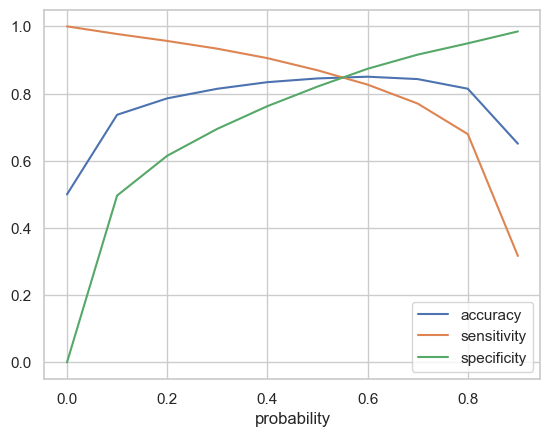

In [199]:
# Plotting accuracy, sensitivity and specificity for different probabilities.
cutoff_df.plot('probability', ['accuracy','sensitivity','specificity'])
plt.show()


Analysis of the above curve Accuracy - Becomes stable around 0.6

Sensitivity - Decreases with the increased probablity.

Specificity - Increases with the increasing probablity.

At point 0.6 where the three parameters cut each other, we can see that there is a balance bethween sensitivity and specificity with a good accuracy.

Here we are intended to acheive better sensitivity than accuracy and specificity. Though as per the above curve, we should take 0.6 as the optimum probability cutoff, we are taking 0.5 for acheiving higher sensitivity, which is our main goal.



In [200]:
# Creating a column with name "predicted", which is the predicted value for 0.5 cutoff 
y_train_pred_final['predicted'] = y_train_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,0.00,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.91,1,1,1,1,1,1,1,1,1,1,1,1
2,0,0.48,2,1,1,1,1,1,0,0,0,0,0,0
3,0,0.00,3,1,0,0,0,0,0,0,0,0,0,0
4,0,0.35,4,1,1,1,1,0,0,0,0,0,0,0


### Metrics

In [201]:
# Confusion metrics
confusion = metrics.confusion_matrix(y_train_pred_final['churn'], y_train_pred_final['predicted'])
print(confusion)

[[18054  3942]
 [ 2874 19122]]


In [202]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [203]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_pred_final['churn'], y_train_pred_final['predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.84506273867976
Sensitivity:- 0.8693398799781779
Specificity:- 0.820785597381342


We have got good accuracy, sensitivity and specificity on the train set prediction.

Plotting the ROC Curve (Trade off between sensitivity & specificity)



In [204]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

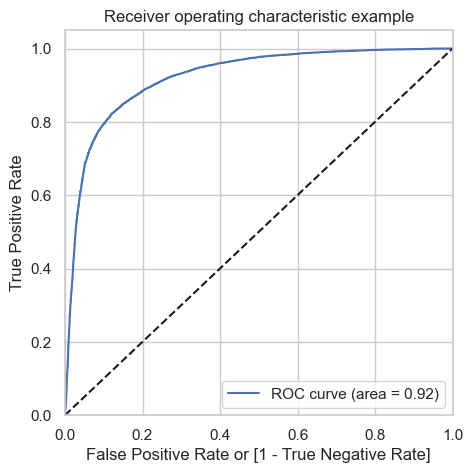

In [205]:
draw_roc(y_train_pred_final['churn'], y_train_pred_final['churn_prob'])


We can see the area of the ROC curve is closer to 1, whic is the Gini of the model.


### Testing the model on the test set


In [206]:
# Taking a copy of the test set
X_test_log = X_test.copy()

In [207]:
# Taking only the columns, which are selected in the train set after removing insignificant and multicollinear variables
X_test_log = X_test_log[log_cols]

In [208]:
# Adding constant on the test set
X_test_sm = sm.add_constant(X_test_log)


Predictions on the test set with final model


In [209]:
# Predict on the test set
y_test_pred = log_no_pca_6.predict(X_test_sm)

In [210]:
y_test_pred.head()

48388                   0.98
29754                   0.00
50131                   0.01
66630                   0.05
91920                   0.53
dtype: float64

In [211]:
# Converting y_test_pred to a dataframe because y_test_pred is an array
y_pred_1 = pd.DataFrame(y_test_pred)
y_pred_1.head()

,0
48388,0.98
29754,0.00
50131,0.01
66630,0.05
91920,0.53


In [212]:
# Convetting y_test to a dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
48388,0
29754,0
50131,0
66630,0
91920,0


In [213]:
# Putting index to Customer ID 
y_test_df['CustID'] = y_test_df.index

In [214]:
# Removing index form the both dataframes for merging them side by side
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [215]:
# Appending y_pred_1 and y_test_df
y_test_pred_final = pd.concat([y_test_df, y_pred_1], axis=1)

In [216]:
y_test_pred_final.head()


,churn,CustID,0
0,0,48388,0.98
1,0,29754,0.00
2,0,50131,0.01
3,0,66630,0.05
4,0,91920,0.53


In [217]:
# Renaming the '0' column as churn probablity
y_test_pred_final = y_test_pred_final.rename(columns={0:'churn_prob'})

In [218]:
y_test_pred_final.columns

Index(['churn', 'CustID', 'churn_prob'], dtype='object')

In [219]:
# Rearranging the columns
y_test_pred_final = y_test_pred_final.reindex(['CustID','churn','churn_prob'], axis='columns')

In [220]:
y_test_pred_final.head()


,CustID,churn,churn_prob
0,48388,0,0.98
1,29754,0,0.00
2,50131,0,0.01
3,66630,0,0.05
4,91920,0,0.53


In [221]:
# In the test set using probablity cutoff 0.5, what we got in the train set 
y_test_pred_final['test_predicted'] = y_test_pred_final['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

In [222]:
y_test_pred_final.head()


,CustID,churn,churn_prob,test_predicted
0,48388,0,0.98,1
1,29754,0,0.00,0
2,50131,0,0.01,0
3,66630,0,0.05,0
4,91920,0,0.53,1


### Metrics

In [223]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test_pred_final['churn'], y_test_pred_final['test_predicted'])
print(confusion)

[[4534  990]
 [  83  384]]


In [224]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


In [225]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test_pred_final['churn'], y_test_pred_final['test_predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))


Accuracy:- 0.8208980136871975
Sensitivity:- 0.8222698072805139
Specificity:- 0.8207820419985518


Model summary

** Train set
  * Accuracy = 0.84
  * Sensitivity = 0.86
  * Specificity = 0.82

** Test set
  * Accuracy = 0.82
  * Sensitivity = 0.82
  * Specificity = 0.82

Overall, the model is performing well in the test set, what it had learnt from the train set.


## Top 15 Features:

In [232]:
log_no_pca_6.params.sort_values(ascending=False)[0:15]

total_rech_amt_data_8                      1.01
avg_loc_ic_t2m_mou_av67                    0.56
avg_arpu_av67                              0.44
avg_max_rech_data_av67                     0.44
avg_total_rech_data_av67                   0.39
avg_sachet_3g_av67                         0.29
avg_loc_ic_t2t_mou_av67                    0.27
avg_std_ic_t2t_mou_av67                    0.21
avg_total_rech_num_av67                    0.19
avg_roam_og_mou_av67                       0.16
roam_og_mou_8                              0.15
max_rech_data_8                            0.14
vol_2g_mb_8                               -0.06
arpu_8                                    -0.09
vbc_3g_8                                  -0.13
dtype: float64

### Final conclusion with no PCA
We can see that the logistic model with no PCA has good sensitivity and accuracy, which are comparable to the models with PCA. So, we can go for the more simplistic model such as logistic regression with PCA as it expliains the important predictor variables as well as the significance of each variable. The model also hels us to identify the variables which should be act upon for making the decision of the to be churned customers. Hence, the model is more relevant in terms of explaining to the business.



## Business recomendation

* To recently joined customers (Tenure: 0-2 years) can be provided add on
  incentives for certain period.

* Provide incentives on recharge of data or voice to high value customers in the
  action phase to increase customer retention.

* Incentives based on usage can be provided to Customer having high ARPU in
  good phase to drive up the ARPU in action phase and retain the customer.

* Can provide free or discounted local onnet and mobile usage voice minutes
  during the action phase.

* To retain customers, we need higher recall. As giving an offer to an user not
  going to churn will cost less as compared to loosing a customer and bring new
  customer, we need to have high rate of correctly identifying the true positives,
  hence recall.

## Recomendations
Target the customers, whose minutes of usage of the incoming local calls and outgoing ISD calls are less in the action phase (mostly in the month of August). Target the customers, whose outgoing others charge in July and incoming others on August are less. Also, the customers having value based cost in the action phase increased are more likely to churn than the other customers. Hence, these customers may be a good target to provide offer. Cutomers, whose monthly 3G recharge in August is more, are likely to be churned. Customers having decreasing STD incoming minutes of usage for operators T to fixed lines of T for the month of August are more likely to churn. Cutomers decreasing monthly 2g usage for August are most probable to churn. Customers having decreasing incoming minutes of usage for operators T to fixed lines of T for August are more likely to churn. roam_og_mou_8 variables have positive coefficients (0.7135). That means for the customers, whose roaming outgoing minutes of usage is increasing are more likely to churn.



## Plots of important predictors for churn and non churn customers


In [226]:
tele_data_final.columns

Index(['mobile_number', 'arpu_8', 'onnet_mou_8', 'offnet_mou_8',
       'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8',
       'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'loc_ic_t2t_mou_8',
       'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8',
       'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'total_rech_data_8', 'max_rech_data_8',
       'av_rech_amt_data_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8',
       'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'aon', 'vbc_3g_8',
       'total_rech_amt_data_8', 'churn', 'avg_arpu_av67', 'avg_onnet_mou_av67',
       'avg_offnet_mou_av67', 'avg_roam_ic_mou_av67', 'avg_roam_og_mou_av67',
       'avg_loc_og_t2t_mou_av67', 'avg_loc_og_t2m_mou_av67',
     

In [227]:
# Creating churn dataframe
data_churn = tele_data_final[tele_data_final['churn'] == 1]
# Creating not churn dataframe
data_non_churn = tele_data_final[tele_data_final['churn'] == 0]

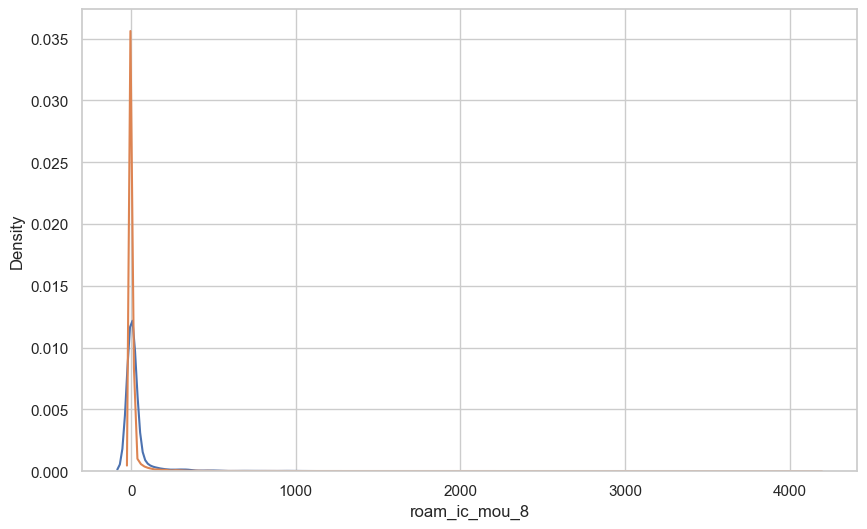

In [228]:
# Plotting 'roam_ic_mou_8' predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['roam_ic_mou_8'],label='churn',hist=False)
sns.distplot(data_non_churn['roam_ic_mou_8'],label='not churn',hist=False)
plt.show()

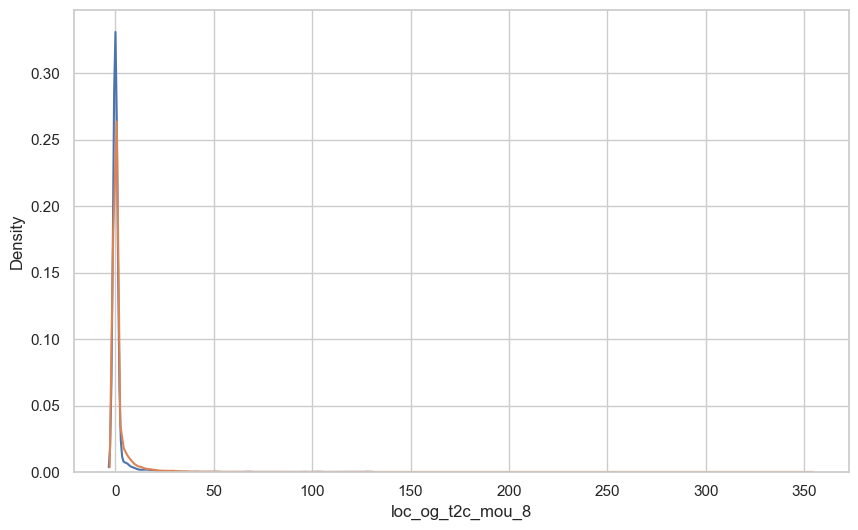

In [229]:
# Plotting 'loc_og_t2c_mou_8' predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['loc_og_t2c_mou_8'],label='churn',hist=False)
sns.distplot(data_non_churn['loc_og_t2c_mou_8'],label='not churn',hist=False)
plt.show()

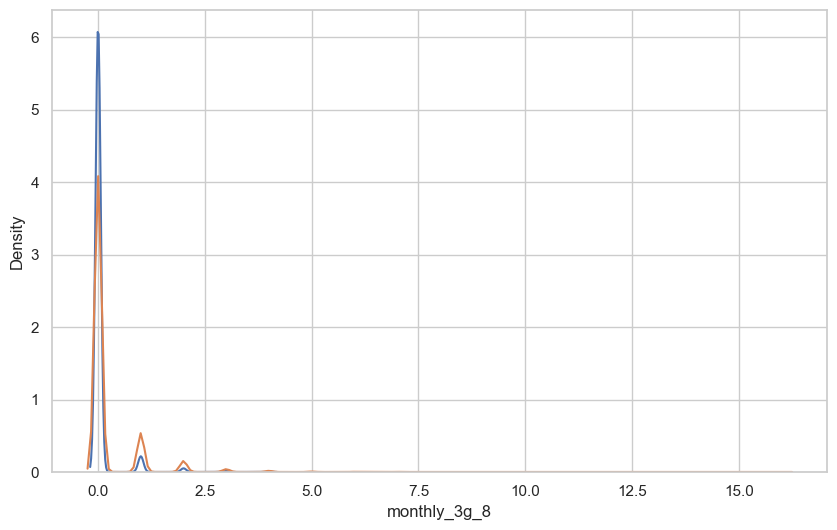

In [230]:
# Plotting monthly_3g_8 predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['monthly_3g_8'],label='churn',hist=False)
sns.distplot(data_non_churn['monthly_3g_8'],label='not churn',hist=False)
plt.show()

The number of mothly 3g data for August for the churn customers are very much populated aroud 1, whereas of non churn customers it spreaded accross various numbers.

Similarly we can plot each variables, which have higher coefficients, churn distribution.

